In [14]:
import matplotlib.pyplot as plt
import numpy as np
import obspy
import seaborn as sns
from scipy import signal
from scipy.signal import butter
from scipy.signal import lfilter
from scipy import fftpack
from scipy.fftpack import fft
from scipy.fftpack import ifft
import matplotlib.colors as colors
from scipy.optimize import curve_fit
from obspy import read
from obspy.core import UTCDateTime
from obspy import read_inventory
from obspy.signal.invsim import paz_to_freq_resp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import numpy as np
from pandas import Series
from pandas import DataFrame
from obspy.signal import PPSD
from pandas.plotting import register_matplotlib_converters
from obspy.imaging.cm import pqlx

In [15]:
register_matplotlib_converters()
# Input parameters
Sta="S14"
Event="SMQ"
start_time="1971-04-17T06h59m00s"
title=Event+" ("+Sta+"_"+start_time+")"

Dir_data="./dataset/SMQ_710417/"+Sta

name_fig1="./"+Event+"_VEL_"+Sta+"_"+start_time+"_LP.png"
name_fig2="./"+Event+"_DU_"+Sta+"_"+start_time+"_LP.png"
name_fig3="./"+Event+"_VEL_"+Sta+"_"+start_time+"_SP.png"
name_fig4="./"+Event+"_DU_"+Sta+"_"+start_time+"_SP.png"

output_file_z="./ppsd/ppsd_sac_ACCz_"+Event+"_"+Sta+".png"
output_file_x="./ppsd/ppsd_sac_ACCx_"+Event+"_"+Sta+".png"
output_file_y="./ppsd/ppsd_sac_ACCy_"+Event+"_"+Sta+".png"

xlabel ="Time from "+start_time+" (s)"
ylabel ="$nm/s$"
label_z = Sta+"LPZ"
label_x = Sta+"LPX"
label_y = Sta+"LPY"
label_sp = Sta+"SPZ"

ymax = 200
psd_max=2e2
psd_min=5e-2

DUmax = 150
psd_max_DU=1e2
psd_min_DU=1e-2

## Bandpass (LP)
freq_low=0.3
freq_high=1.5
pre_low=0.05 #used for prefiltering
pre_high=3.0 #used for prefiltering
## Bandpass (SP)
freq_low_sp=1.0
freq_high_sp=10.0
pre_low_sp=0.1 #used for prefiltering
pre_high_sp=26.0 #used for prefiltering

vmax = psd_max/2
vmin = psd_min
cmap = plt.get_cmap("jet", lut = 300)

num_mv_Apo = 200 ## The number of samples used for moving average
font = 22
time=50 ## time width for spectrogram f_lp*time (s)
loc_legend='lower right'

In [16]:
print("################# Read Apollo Seismic Data ###################")
st_NI1_lpz = read(Dir_data+"/SMQ_LPZ.sac") 
st_NI1_lpx = read(Dir_data+"/SMQ_LPX.sac") 
st_NI1_lpy = read(Dir_data+"/SMQ_LPY.sac") 
st_NI1_spz = read(Dir_data+"/SMQ_SPZ.sac") 
DU_lpz=st_NI1_lpz.copy()
DU_lpx=st_NI1_lpx.copy()
DU_lpy=st_NI1_lpy.copy()
DU_spz=st_NI1_spz.copy()

f_lp = 6.6 ## Sampling rate
f_sp = 53 ## Sampling rate
N = st_NI1_lpz[0].data.size
N_sp=st_NI1_spz[0].data.size

################# Read Apollo Seismic Data ###################


In [17]:
########## Apollo response curve ##############
LP_t_samp=1/f_lp #sec
LP_nfft = N #Sample Number of Simulation output
SP_t_samp=1/f_sp #sec
SP_nfft = N_sp #Sample Number of Simulation output

#Convert Poles and Zeros to Frequency Response (LP Flat)
AF_scale_fac = 5.18524045674722E+18
AF_zeros = [-9.97000000000000E-04 -0.00000000000000E+00j, 0.00000000000000E+00 + 0.00000000000000E+00j, 0.00000000000000E+00 + 0.00000000000000E+00j, 0.00000000000000E+00 + 0.00000000000000E+00j]
AF_poles = [-6.28000000000000E-02 + 0.00000000000000E+00j, -4.76199964295322E+01 + 0.00000000000000E+00j, -5.94194170468653E-02 + 0.00000000000000E+00j, -3.26855546475662E-01 + -1.74189592000858E-01j, -3.26855546475662E-01 + 1.74189592000858E-01j, -3.33954437504881E+00 -8.06237332238962E+00j, -3.33954437504881E+00 + 8.06237332238962E+00j, -3.33954437504881E+00 -8.06237332238962E+00j, -3.33954437504881E+00 + 8.06237332238962E+00j, -8.06237332238962E+00 -3.33954437504881E+00j, -8.06237332238962E+00 + 3.33954437504881E+00j, -8.06237332238962E+00 -3.33954437504881E+00j, -8.06237332238962E+00 + 3.33954437504881E+00j]
AF_h, AF_f=paz_to_freq_resp(AF_poles, AF_zeros, AF_scale_fac, LP_t_samp, LP_nfft, freq=True)
#Convert Poles and Zeros to Frequency Response (LP Peak)
AP_scale_fac = 5.18524045674722E+18
AP_zeros = [0.00000000000000E+00 + 0.00000000000000E+00j, 0.00000000000000E+00 + 0.00000000000000E+00j, 0.00000000000000E+00 + 0.00000000000000E+00j]
AP_poles = [-6.28000000000000E-02 + 0.00000000000000E+00j, -4.77893183981691E+01 + 0.00000000000000E+00j, -2.71405770680666E-01 -2.84127616186138E+00j, -2.71405770680666E-01 + 2.84127616186138E+00j, -3.33954437504881E+00 -8.06237332238962E+00j, -3.33954437504881E+00 + 8.06237332238962E+00j, -3.33954437504881E+00 -8.06237332238962E+00j, -3.33954437504881E+00 + 8.06237332238962E+00j, -8.06237332238962E+00 -3.33954437504881E+00j, -8.06237332238962E+00 + 3.33954437504881E+00j, -8.06237332238962E+00 -3.33954437504881E+00j, -8.06237332238962E+00 + 3.33954437504881E+00j]
AP_h, AP_f=paz_to_freq_resp(AP_poles, AP_zeros, AP_scale_fac, LP_t_samp, LP_nfft, freq=True)
#Convert Poles and Zeros to Frequency Response (LP Tidal)
SP_scale_fac = 5.76082444429034E+22
SP_zeros = [0.0 + 0.0j,0.0 + 0.0j,0.0 + 0.0j,0.0 + 0.0j]
SP_poles = [-5.34070751110265E+00 + 3.30987324307279E+00j,-5.34070751110265E+00 - 3.30987324307279E+00j,-0.31416000000000E+00 + 0.00000000000000E+00j,-5.27719065090915E+01 + 2.18588393883507E+01j,-5.27719065090915E+01 + 2.18588393883507E+01j,-5.27719065090915E+01 - 2.18588393883507E+01j,-5.27719065090915E+01 - 2.18588393883507E+01j,-2.18588393883507E+01 + 5.27719065090915E+01j,-2.18588393883507E+01 + 5.27719065090915E+01j,-2.18588393883507E+01 - 5.27719065090915E+01j,-2.18588393883507E+01 - 5.27719065090915E+01j]
SP_h, SP_f = paz_to_freq_resp(SP_poles, SP_zeros, SP_scale_fac, SP_t_samp, SP_nfft, freq=True)
################## Seismometer Correction #########################
AF_A0 = 1735742164.9349701 # gain
AF_Ds = 3736331684.7959046 # Sensitivity
AP_A0 = 1387789118.8962953 # gain
AP_Ds = 2987333350.251064  # Sensitivity
#TD_A0 = 4.81281409448854E+01
#TD_Ds = ???
SP_A0 = 5695016579508.034 # gain
SP_Ds = 10115553420.896257 # Sensitivity
paz_AF = {'poles': AF_poles,'zeros': AF_zeros,'gain': AF_A0,'sensitivity': AF_Ds}
paz_AP = {'poles': AP_poles,'zeros': AP_zeros,'gain': AP_A0,'sensitivity': AP_Ds}
paz_SP = {'poles': SP_poles,'zeros': SP_zeros,'gain': SP_A0,'sensitivity': SP_Ds}

# 前処理

In [291]:
from copy import deepcopy
import pandas as pd
data = deepcopy(st_NI1_lpz[0].data)

data = Series(data)

def plot_outlier(ts, span_mean=1000, span_std=10000, threshold=3.0):
    assert type(ts) == pd.Series
    ret_ts = ts.copy()
    for _ in [0]*5:
        fig, ax = plt.subplots(figsize=(24, 8))

        ewm_mean = ret_ts.ewm(span=span_mean).mean()  # 指数加重移動平均
        ewm_std = ret_ts.ewm(span=span_std).std()  # 指数加重移動標準偏差
        ax.plot(ret_ts, label='original', color='blue')
        ax.plot(ewm_mean, label='ewma', color='green')

        # 標準偏差から 3.0 倍以上外れているデータを外れ値としてプロットする
        ax.fill_between(ret_ts.index,
                        ewm_mean - ewm_std * threshold,
                        ewm_mean + ewm_std * threshold,
                        alpha=0.2)
        outlier = ret_ts[(ret_ts - ewm_mean).abs() > ewm_std * threshold]
        ax.scatter(outlier.index, outlier, label='outlier', color='red')

        ax.legend()
        plt.show()

        ret_ts[outlier.index] = ewm_mean[outlier.index]
    return ret_ts

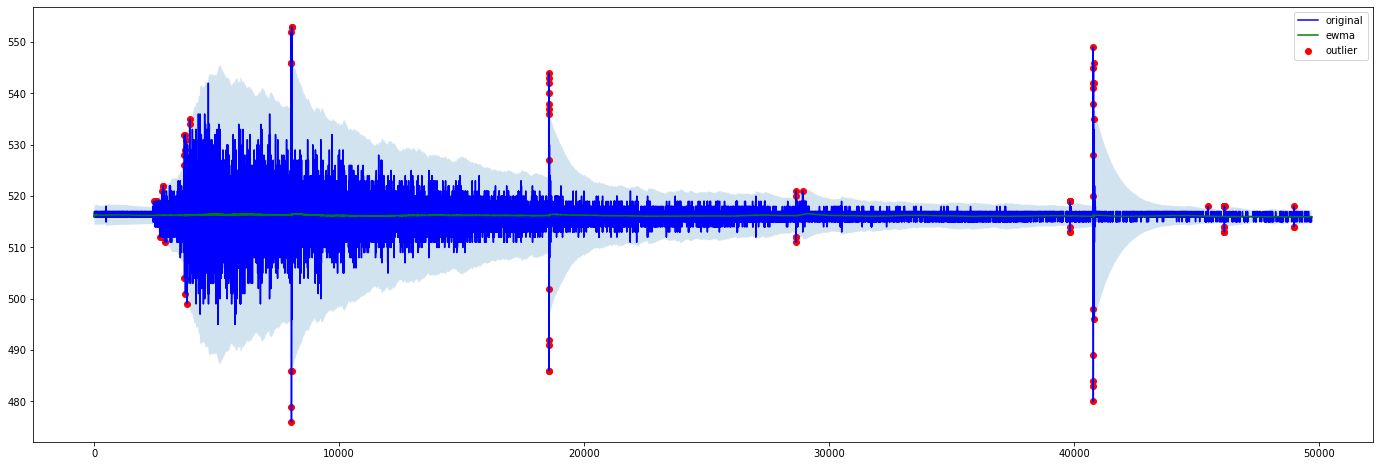

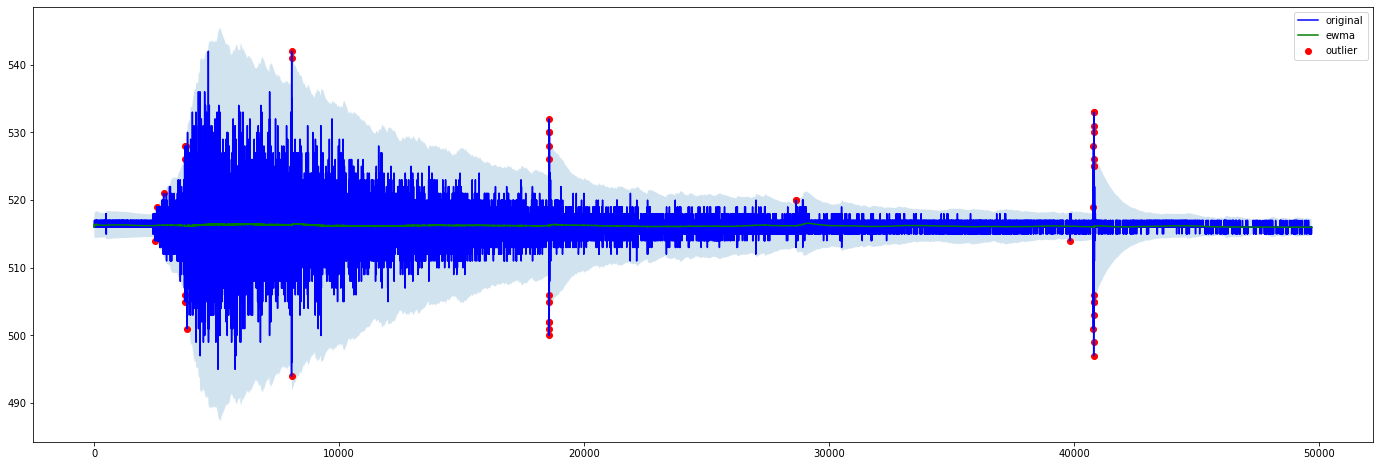

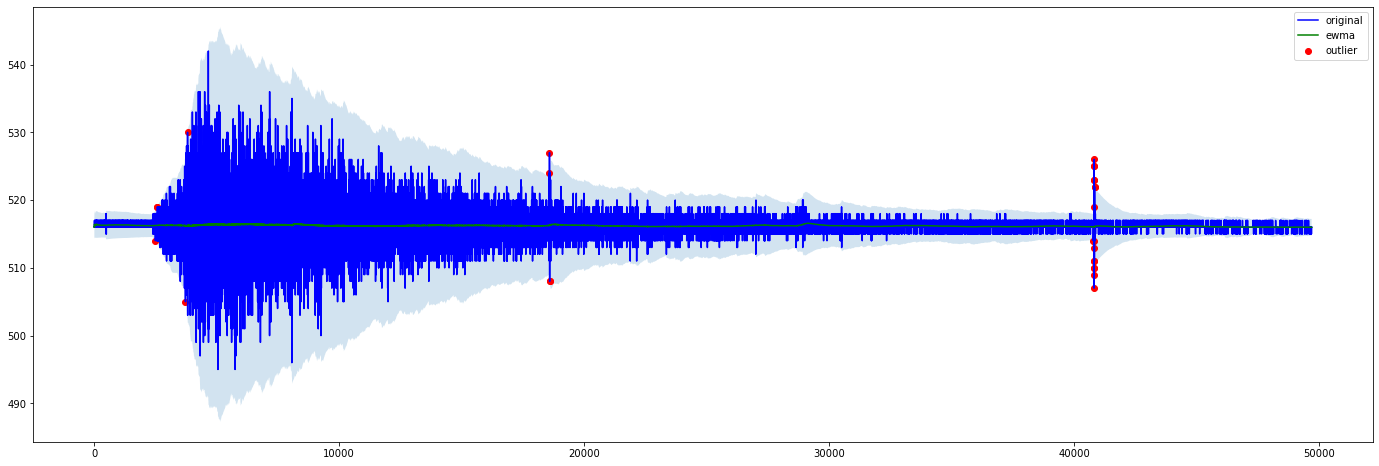

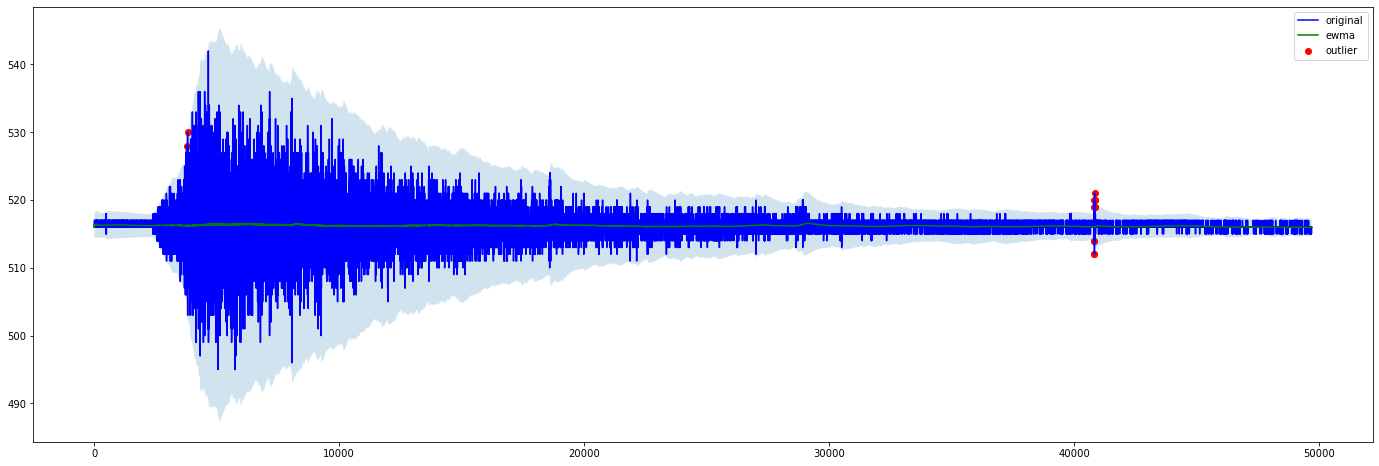

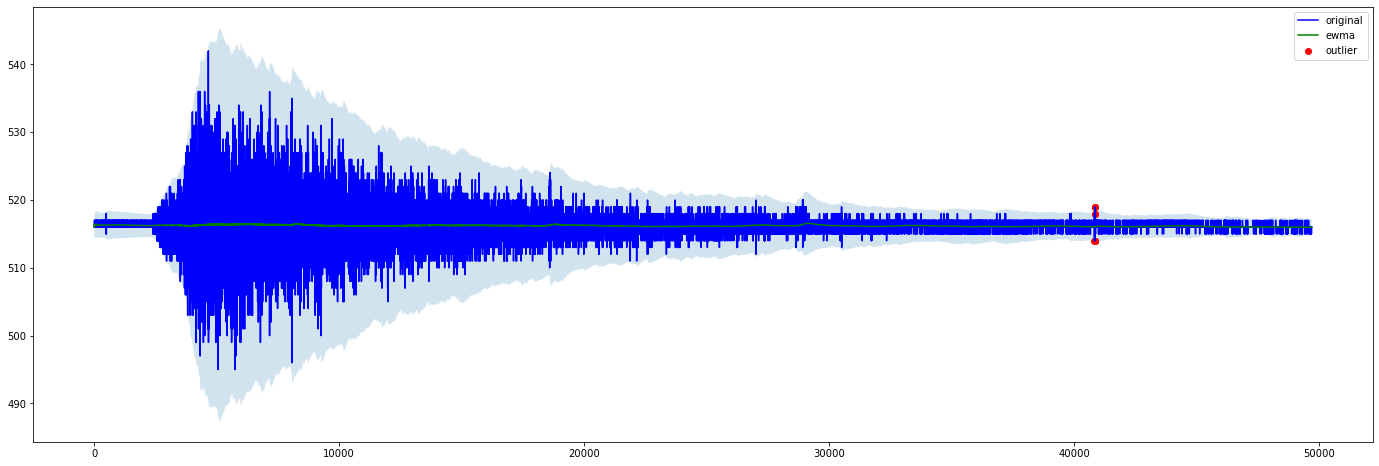

In [292]:
aaa = plot_outlier(data, 1000, 1000, 4)

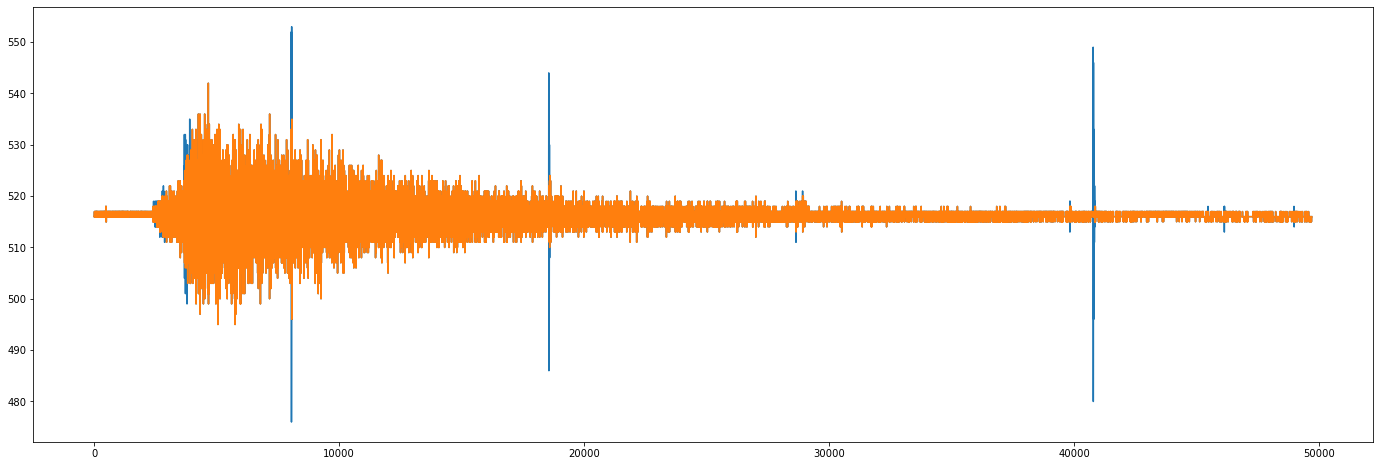

In [293]:
plt.figure(figsize=(24, 8))
data.plot()
aaa.plot()
plt.show()

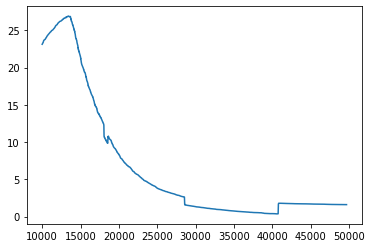

In [299]:
plt.plot(data.rolling(10000).var())
# plt.plot(data)

<AxesSubplot:>

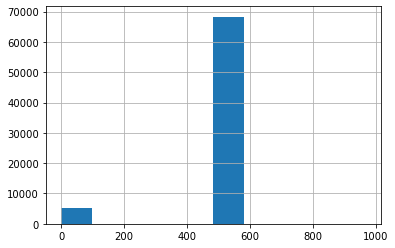

In [259]:
data.hist()

<AxesSubplot:>

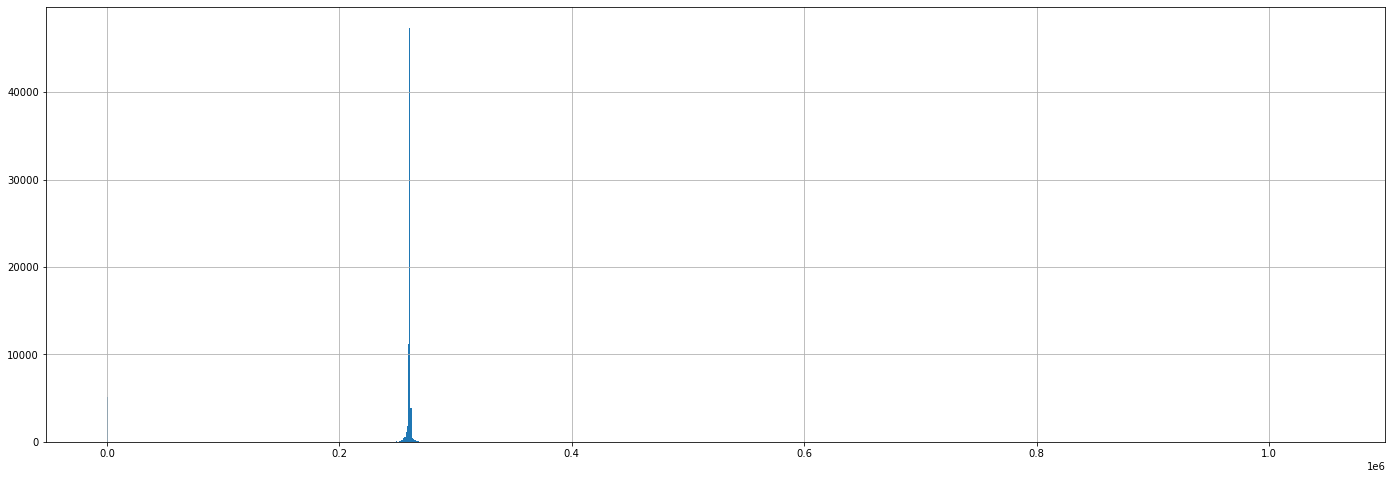

In [270]:
import numpy as np
(data*data).hist(bins=np.arange(0, 1024*1024, 1024), figsize=(24, 8))

In [208]:
print("############# Analysis Wave Data #################")
### Convert into Physical Value
print("LPZ")
st_NI1_lpz.detrend(type='linear') #detrend
st_NI1_lpz.detrend('demean') #rmean
st_NI1_lpz.taper(0.05,type='cosine')
st_NI1_lpz.filter('lowpass', freq=pre_high, zerophase=True)
st_NI1_lpz.filter('highpass', freq=pre_low, zerophase=True)
st_NI1_lpz.simulate(paz_remove=paz_AP) # Remove response
st_NI1_lpz.taper(0.05,type='cosine')
st_NI1_lpz.differentiate(method='gradient')
st_NI1_lpz_PSD=st_NI1_lpz[0].data
st_NI1_lpz.filter('lowpass', freq=freq_high, zerophase=True)
st_NI1_lpz.filter('highpass', freq=freq_low, zerophase=True)

print("LPX")
st_NI1_lpx.detrend('demean') #rmean
st_NI1_lpx.detrend(type='linear') #detrend
st_NI1_lpx.taper(0.05,type='cosine')
st_NI1_lpx.filter('lowpass', freq=pre_high, zerophase=True)
st_NI1_lpx.filter('highpass', freq=pre_low, zerophase=True)
st_NI1_lpx.simulate(paz_remove=paz_AP) # Remove response
st_NI1_lpx.taper(0.05,type='cosine')
st_NI1_lpx.differentiate(method='gradient')
st_NI1_lpx_PSD=st_NI1_lpx[0].data
st_NI1_lpx.filter('lowpass', freq=freq_high, zerophase=True)
st_NI1_lpx.filter('highpass', freq=freq_low, zerophase=True)

print("LPY")
st_NI1_lpy.detrend('demean') #rmean
st_NI1_lpy.detrend(type='linear') #detrend
st_NI1_lpy.taper(0.05,type='cosine')
st_NI1_lpy.filter('lowpass', freq=pre_high, zerophase=True)
st_NI1_lpy.filter('highpass', freq=pre_low, zerophase=True)
st_NI1_lpy.simulate(paz_remove=paz_AP) # Remove response
st_NI1_lpy.taper(0.05,type='cosine')
st_NI1_lpy.differentiate(method='gradient')
st_NI1_lpy_PSD=st_NI1_lpy[0].data
st_NI1_lpy.filter('lowpass', freq=freq_high, zerophase=True)
st_NI1_lpy.filter('highpass', freq=freq_low, zerophase=True)

print("SPZ")
st_NI1_spz.detrend('demean') #rmean
st_NI1_spz.detrend(type='linear') #detrend
st_NI1_spz.taper(0.05,type='cosine')
st_NI1_spz.filter('lowpass', freq=pre_high_sp, zerophase=True)
st_NI1_spz.filter('highpass', freq=pre_low_sp, zerophase=True)
st_NI1_spz.simulate(paz_remove=paz_SP) # Remove response
st_NI1_spz.taper(0.05,type='cosine')
st_NI1_spz.differentiate(method='gradient')
st_NI1_spz_PSD=st_NI1_spz[0].data
st_NI1_spz.filter('lowpass', freq=freq_high_sp, zerophase=True)
st_NI1_spz.filter('highpass', freq=freq_low_sp, zerophase=True)

### Envelope (VEL)
Env_st_NI1_lpz=obspy.signal.filter.envelope(st_NI1_lpz[0].data*1e9)
Env_st_NI1_lpx=obspy.signal.filter.envelope(st_NI1_lpx[0].data*1e9)
Env_st_NI1_lpy=obspy.signal.filter.envelope(st_NI1_lpy[0].data*1e9)
Env_st_NI1_spz=obspy.signal.filter.envelope(st_NI1_spz[0].data*1e9)

### Moving Average
b = np.ones(num_mv_Apo)/num_mv_Apo
b_s = np.ones(int(num_mv_Apo*10))/int(num_mv_Apo*10)
Mv_NI1_lpz = np.convolve(Env_st_NI1_lpz, b, mode='same') ## Moving Average (nm/s)
Mv_NI1_lpx = np.convolve(Env_st_NI1_lpx, b, mode='same') ## Moving Average (nm/s)
Mv_NI1_lpy = np.convolve(Env_st_NI1_lpy, b, mode='same') ## Moving Average (nm/s)
Mv_NI1_spz = np.convolve(Env_st_NI1_spz, b_s, mode='same') ## Moving Average (nm/s)

############# Analysis Wave Data #################
LPZ
LPX
LPY
SPZ


############# Plot #################
Waveform in nm/s
Envelope
Power Spectral Density in nm/s/√Hz
Spectrogram


<ipython-input-6-4867134cd767>:102: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(tx,fx,np.sqrt(Sx), cmap=cmap, norm=colors.LogNorm(vmin=psd_min, vmax=psd_max/2))
<ipython-input-6-4867134cd767>:114: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ty,fy,np.sqrt(Sy), cmap=cmap, norm=colors.LogNorm(vmin=psd_min, vmax=psd_max/2))
<ipython-input-6-4867134cd767>:126: MatplotlibDeprecationWarning: shading='flat' when X and Y have the sam

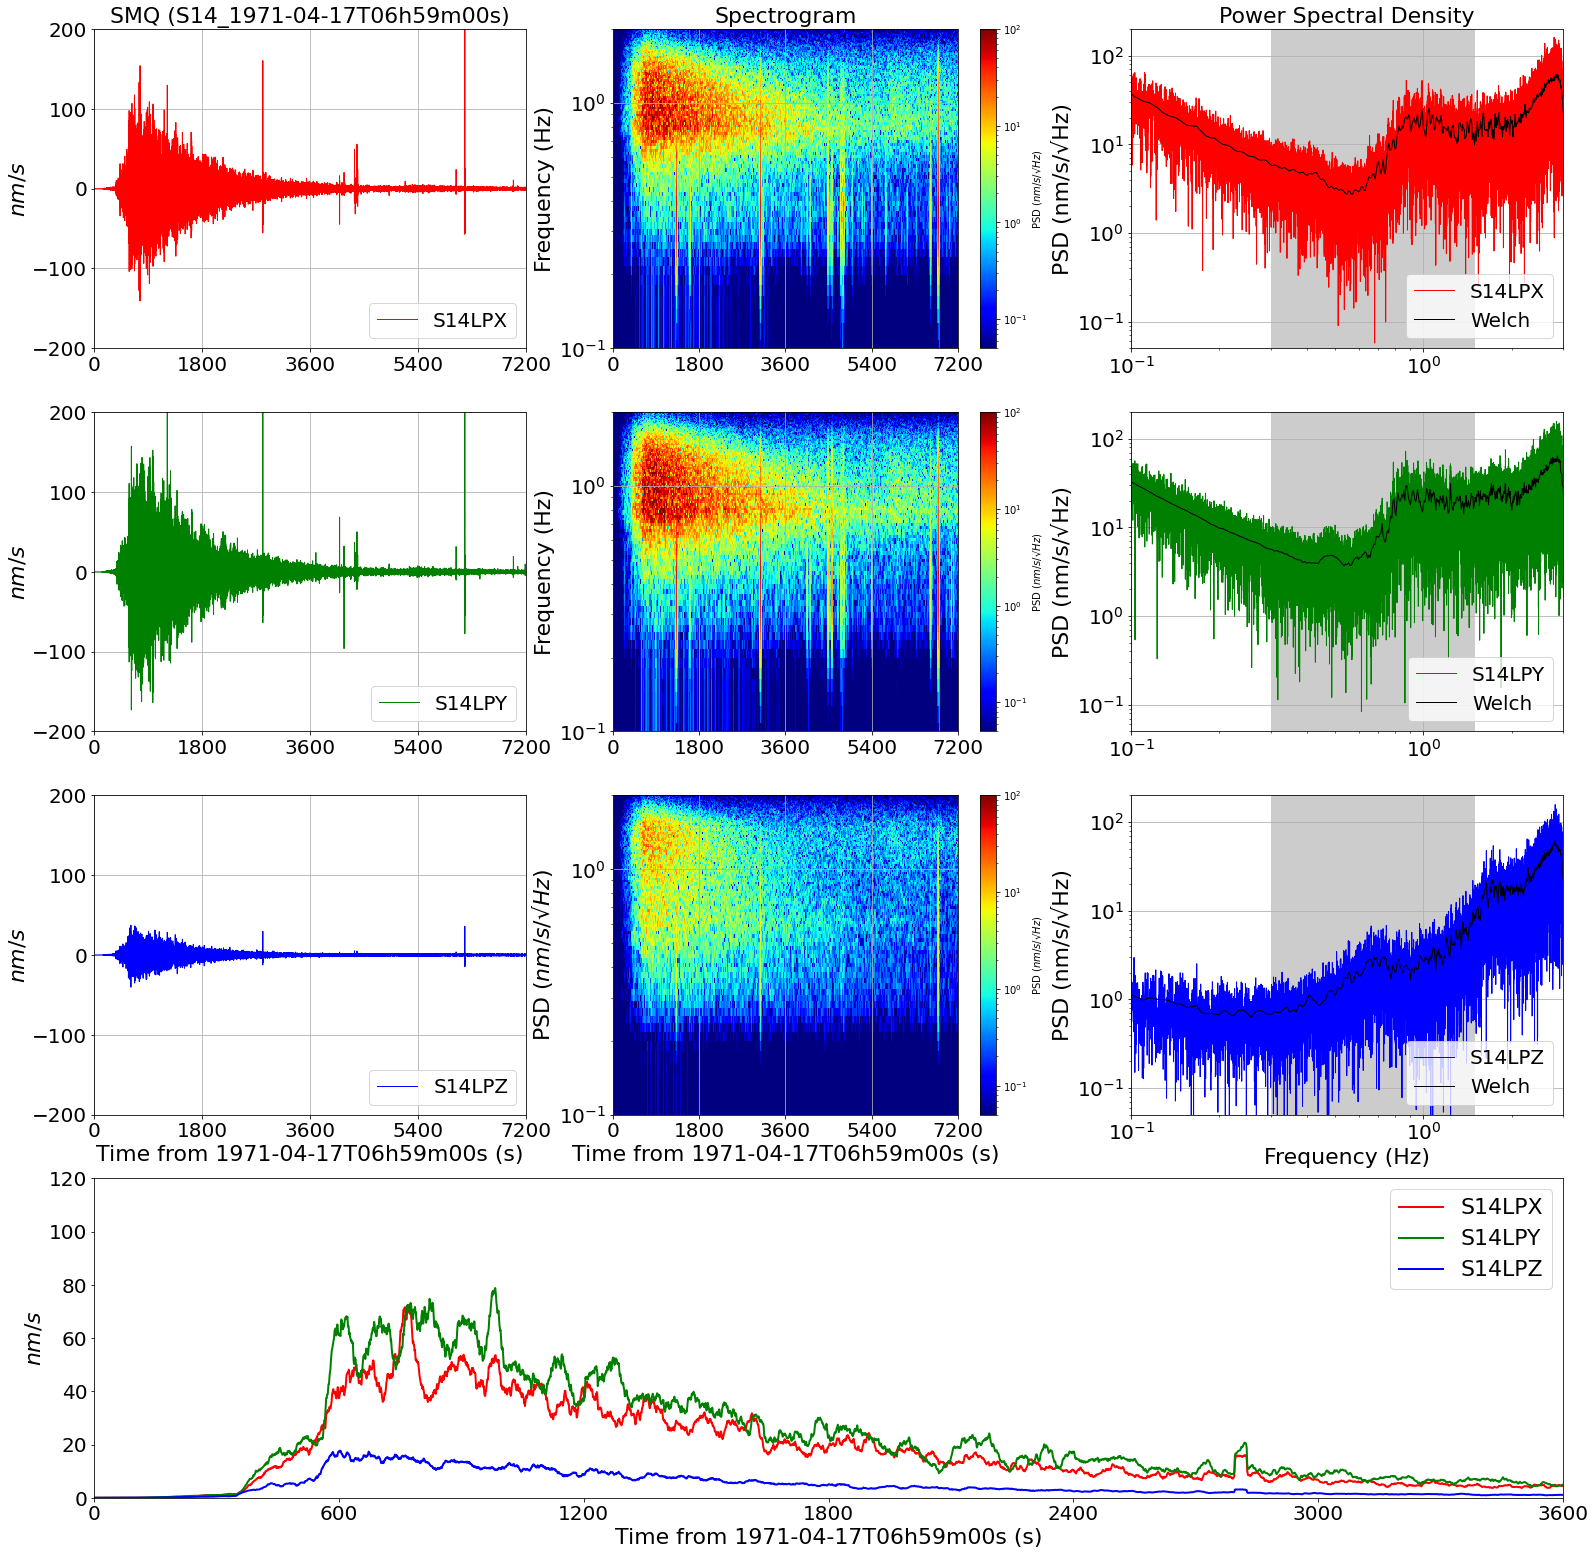

In [6]:
print("############# Plot #################")
print("Waveform in nm/s")
fig = plt.figure(figsize=(24,24))
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)
t_NI_LP = np.linspace(0, st_NI1_lpz[0].data.size*1/f_lp, st_NI1_lpz[0].data.size)
ax = fig.add_subplot(4, 3, 1)
plt.title(title, fontsize=font)
ax.plot(t_NI_LP, st_NI1_lpx[0].data*1e9, "r-", label = label_x, linewidth=1.0)
ax.set_ylabel(ylabel, fontsize=font)
plt.grid()
plt.tick_params(labelsize=font-2)
plt.legend(fontsize=font-2, loc=loc_legend)
ax.set_ylim(-1*ymax, ymax)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])
ax = fig.add_subplot(4, 3, 4)
ax.plot(t_NI_LP, st_NI1_lpy[0].data*1e9, "g-", label = label_y, linewidth=1.0)
ax.set_ylabel(ylabel, fontsize=font)
plt.grid()
plt.tick_params(labelsize=font-2)
plt.legend(fontsize=font-2, loc=loc_legend)
ax.set_ylim(-1*ymax, ymax)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])
ax = fig.add_subplot(4, 3, 7)
ax.plot(t_NI_LP, st_NI1_lpz[0].data*1e9, "b-", label = label_z, linewidth=1.0)
ax.set_ylabel(ylabel, fontsize=font)
ax.set_xlabel(xlabel, fontsize=font)
plt.grid()
plt.tick_params(labelsize=font-2)
plt.legend(fontsize=font-2, loc=loc_legend)
ax.set_ylim(-1*ymax, ymax)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])

print("Envelope")
ax = fig.add_subplot(4, 1, 4)
ax.plot(t_NI_LP, Mv_NI1_lpx, "r-", label = label_x, linewidth=2.0)
ax.plot(t_NI_LP, Mv_NI1_lpy, "g-", label = label_y, linewidth=2.0)
ax.plot(t_NI_LP, Mv_NI1_lpz, "b-", label = label_z, linewidth=2.0)
ax.set_xlim(0, 3600)
ax.set_xticks([0,600,1200,1800, 2400, 3000, 3600])
ax.set_ylim(0, ymax*0.6)
plt.tick_params(labelsize=font-2)
ax.set_xlabel(xlabel, fontsize=font)
ax.set_ylabel("$nm/s$", fontsize=font)
plt.legend(fontsize=font, loc='upper right')

print("Power Spectral Density in nm/s/√Hz")
ax = fig.add_subplot(4, 3, 3)
plt.title("Power Spectral Density", fontsize=font)
plt.axvspan(freq_low, freq_high, color='grey', alpha=0.4, lw=0)
fx, Px = signal.periodogram(st_NI1_lpx_PSD*1e9, f_lp)
plt.plot(fx, np.sqrt(Px), "r-", linewidth=1.0,label=label_x)
fx_wl, Px_wl = signal.welch(st_NI1_lpx_PSD*1e9, f_lp , nperseg=1024, noverlap=512, scaling='density', average='mean') 
plt.plot(fx_wl, np.sqrt(Px_wl), "k-", linewidth=1.0,label="Welch")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-1, 3.0)
plt.tick_params(labelsize=font-2)
ax.set_ylim(psd_min, psd_max)
#ax.set_xlabel('Frequency (Hz)', fontsize=font)
ax.set_ylabel('PSD (nm/s/√Hz)', fontsize=font)
plt.legend(fontsize=font-2, loc=loc_legend)
plt.grid()
ax = fig.add_subplot(4, 3, 6)
plt.axvspan(freq_low, freq_high, color='grey', alpha=0.4, lw=0)
fy, Py = signal.periodogram(st_NI1_lpy_PSD*1e9, f_lp)
plt.plot(fy, np.sqrt(Py), "g-", linewidth=1.0,label=label_y)
fy_wl, Py_wl = signal.welch(st_NI1_lpy_PSD*1e9, f_lp , nperseg=1024, noverlap=512, scaling='density', average='mean') 
plt.plot(fy_wl, np.sqrt(Py_wl), "k-", linewidth=1.0,label="Welch")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-1, 3.0)
plt.tick_params(labelsize=font-2)
ax.set_ylim(psd_min, psd_max)
#ax.set_xlabel('Frequency (Hz)', fontsize=font)
ax.set_ylabel('PSD (nm/s/√Hz)', fontsize=font)
plt.legend(fontsize=font-2, loc=loc_legend)
plt.grid()
ax = fig.add_subplot(4, 3, 9)
plt.axvspan(freq_low, freq_high, color='grey', alpha=0.4, lw=0)
fz, Pz = signal.periodogram(st_NI1_lpz_PSD*1e9, f_lp)
plt.plot(fz, np.sqrt(Pz), "b-", linewidth=1.0,label=label_z)
fz_wl, Pz_wl = signal.welch(st_NI1_lpz_PSD*1e9, f_lp , nperseg=1024, noverlap=512, scaling='density', average='mean') 
plt.plot(fz_wl, np.sqrt(Pz_wl), "k-", linewidth=1.0,label="Welch")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-1, 3.0)
plt.tick_params(labelsize=font-2)
ax.set_ylim(psd_min, psd_max)
ax.set_xlabel('Frequency (Hz)', fontsize=font)
ax.set_ylabel('PSD (nm/s/√Hz)', fontsize=font)
plt.legend(fontsize=font-2, loc=loc_legend)
plt.grid()

print("Spectrogram")
ax = fig.add_subplot(4, 3, 2)
plt.title("Spectrogram", fontsize=font)
fx,tx,Sx = signal.spectrogram(st_NI1_lpx[0].data*1e9, nfft=int(f_lp*time), nperseg=int(f_lp*time), fs=int(f_lp), noverlap=int(f_lp*time-1), scaling='density',mode='psd', window=('hamming'))
#plt.pcolormesh(tx,fx,np.sqrt(Sx), cmap=cmap, norm=colors.LogNorm())
plt.pcolormesh(tx,fx,np.sqrt(Sx), cmap=cmap, norm=colors.LogNorm(vmin=psd_min, vmax=psd_max/2))
ax.set_ylabel("Frequency (Hz)", fontsize=font)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])
ax.set_ylim(0.1, 2.0)
plt.tick_params(labelsize=font-2)
ax.set_yscale("log")
plt.colorbar(orientation ='vertical', label='PSD ($nm/s/√Hz$)')
plt.grid(which='major')
ax = fig.add_subplot(4, 3, 5)
fy,ty,Sy = signal.spectrogram(st_NI1_lpy[0].data*1e9, nfft=int(f_lp*time), nperseg=int(f_lp*time), fs=int(f_lp), noverlap=int(f_lp*time-1), scaling='density',mode='psd', window=('hamming'))
#plt.pcolormesh(ty,fy,np.sqrt(Sy), cmap=cmap, norm=colors.LogNorm())
plt.pcolormesh(ty,fy,np.sqrt(Sy), cmap=cmap, norm=colors.LogNorm(vmin=psd_min, vmax=psd_max/2))
ax.set_ylabel("Frequency (Hz)", fontsize=font)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])
ax.set_ylim(0.1, 2.0)
plt.tick_params(labelsize=font-2)
ax.set_yscale("log")
plt.colorbar(orientation ='vertical', label='PSD ($nm/s/√Hz$)')
plt.grid(which='major')
ax = fig.add_subplot(4, 3, 8)
fz,tz,Sz = signal.spectrogram(st_NI1_lpz[0].data*1e9, nfft=int(f_lp*time), nperseg=int(f_lp*time), fs=int(f_lp), noverlap=int(f_lp*time-1), scaling='density',mode='psd', window=('hamming'))
#plt.pcolormesh(tz,fz,np.sqrt(Sz), cmap=cmap, norm=colors.LogNorm())
plt.pcolormesh(tz,fz,np.sqrt(Sz), cmap=cmap, norm=colors.LogNorm(vmin=psd_min, vmax=psd_max/2))
ax.set_ylabel("Frequency (Hz)", fontsize=font)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])
ax.set_ylim(0.1, 2.0)
plt.tick_params(labelsize=font-2)
ax.set_yscale("log")
plt.colorbar(orientation ='vertical', label='PSD ($nm/s/√Hz$)')
plt.grid(which='major')
ax.set_ylabel('PSD ($nm/s/√Hz$)')
ax.set_xlabel(xlabel, fontsize=font)
plt.show()

############# Analysis Wave Data #################
LPZ (DU)
LPX (DU)
LPY (DU)
SPZ (DU)
############# Plot #################
Waveform in DU
Envelope
Power Spectral Density in DU/√Hz
Spectrogram


<ipython-input-7-1d35d7408349>:98: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(AP_f, (Resp_Peak/np.sqrt(AP_f))*psd_max_DU/20, 'k--', linewidth=2.0,label='Apollo-LP (Peaked)')
<ipython-input-7-1d35d7408349>:112: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(AP_f, (Resp_Peak/np.sqrt(AP_f))*psd_max_DU/20, 'k--', linewidth=2.0,label='Apollo-LP (Peaked)')
<ipython-input-7-1d35d7408349>:127: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(AP_f, (Resp_Peak/np.sqrt(AP_f))*psd_max_DU/20, 'k--', linewidth=2.0,label='Apollo-LP (Peaked)')
<ipython-input-7-1d35d7408349>:144: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(tx,fx,np.sqrt(Sx), cmap=cmap, norm=

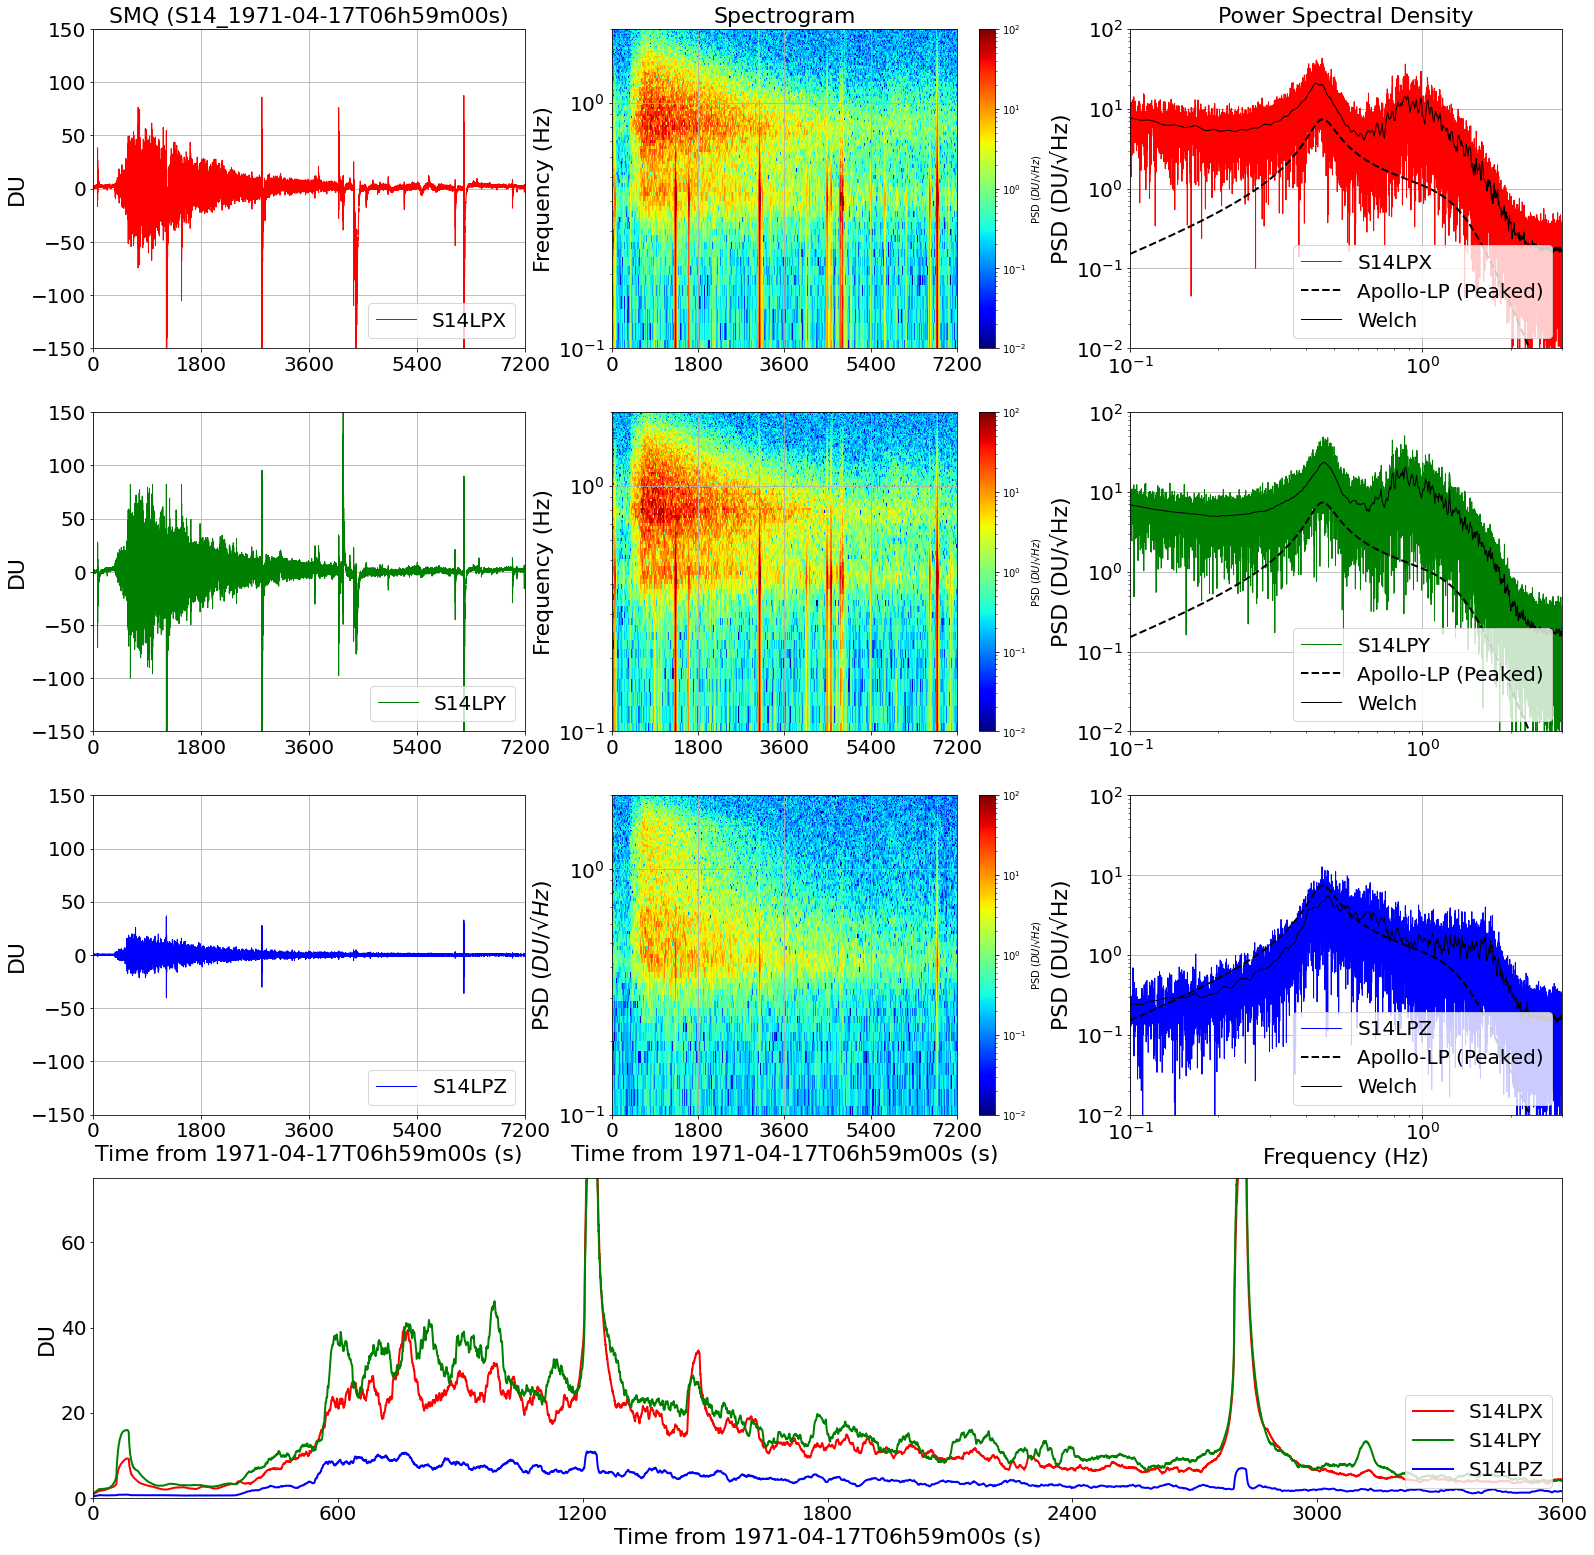

In [7]:
###############################################################
###################      plot 2     ###########################
###############################################################
print("############# Analysis Wave Data #################")
### Convert into Physical Value
print("LPZ (DU)")
DU_lpz.detrend(type='linear') #detrend
DU_lpz.detrend('demean') #rmean
DU_lpz_PSD=DU_lpz[0].data

print("LPX (DU)")
DU_lpx.detrend(type='linear') #detrend
DU_lpx.detrend('demean') #rmean
DU_lpx_PSD=DU_lpx[0].data

print("LPY (DU)")
DU_lpy.detrend(type='linear') #detrend
DU_lpy.detrend('demean') #rmean
DU_lpy_PSD=DU_lpy[0].data

print("SPZ (DU)")
DU_spz.detrend(type='linear') #detrend
DU_spz.detrend('demean') #rmean
DU_spz_PSD=DU_spz[0].data

### Envelope
Env_DU_lpz=obspy.signal.filter.envelope(DU_lpz[0].data)
Env_DU_lpx=obspy.signal.filter.envelope(DU_lpx[0].data)
Env_DU_lpy=obspy.signal.filter.envelope(DU_lpy[0].data)
Env_DU_spz=obspy.signal.filter.envelope(DU_spz[0].data)

### Moving Average
Mv_DU_lpz = np.convolve(Env_DU_lpz, b, mode='same') ## Moving Average (DU)
Mv_DU_lpx = np.convolve(Env_DU_lpx, b, mode='same') ## Moving Average (DU)
Mv_DU_lpy = np.convolve(Env_DU_lpy, b, mode='same') ## Moving Average (DU)
Mv_DU_spz = np.convolve(Env_DU_spz, b, mode='same') ## Moving Average (DU)

print("############# Plot #################")
print("Waveform in DU")
fig = plt.figure(figsize=(24,24))
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)
t_DU_LP = np.linspace(0, DU_lpz[0].data.size*1/f_lp, DU_lpz[0].data.size)
ax = fig.add_subplot(4, 3, 1)
plt.title(title, fontsize=font)
ax.plot(t_DU_LP, DU_lpx[0].data, "r-", label = label_x, linewidth=1.0)
ax.set_ylabel("DU", fontsize=font)
plt.grid()
plt.tick_params(labelsize=font-2)
plt.legend(fontsize=font-2, loc=loc_legend)
ax.set_ylim(-1*DUmax, DUmax)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])
ax = fig.add_subplot(4, 3, 4)
ax.plot(t_DU_LP, DU_lpy[0].data, "g-", label = label_y, linewidth=1.0)
ax.set_ylabel("DU", fontsize=font)
plt.grid()
plt.tick_params(labelsize=font-2)
plt.legend(fontsize=font-2, loc=loc_legend)
ax.set_ylim(-1*DUmax, DUmax)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])
ax = fig.add_subplot(4, 3, 7)
ax.plot(t_DU_LP, DU_lpz[0].data, "b-", label = label_z, linewidth=1.0)
ax.set_ylabel("DU", fontsize=font)
ax.set_xlabel(xlabel, fontsize=font)
plt.grid()
plt.tick_params(labelsize=font-2)
plt.legend(fontsize=font-2, loc=loc_legend)
ax.set_ylim(-1*DUmax, DUmax)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])

print("Envelope")
ax = fig.add_subplot(4, 1, 4)
ax.plot(t_DU_LP, Mv_DU_lpx, "r-", label = label_x, linewidth=2.0)
ax.plot(t_DU_LP, Mv_DU_lpy, "g-", label = label_y, linewidth=2.0)
ax.plot(t_DU_LP, Mv_DU_lpz, "b-", label = label_z, linewidth=2.0)
ax.set_xlim(0, 3600)
ax.set_xticks([0,600,1200,1800, 2400, 3000, 3600])
ax.set_ylim(0, DUmax*0.5)
plt.tick_params(labelsize=font-2)
ax.set_xlabel(xlabel, fontsize=font)
ax.set_ylabel("DU", fontsize=font)
plt.legend(fontsize=font-2, loc=loc_legend)


print("Power Spectral Density in DU/√Hz")
## Normalize
Resp_Peak=abs(AP_h)/np.max(abs(AP_h))
Resp_Flat=abs(AF_h)/np.max(abs(AF_h))
Resp_SP=abs(SP_h)/np.max(abs(SP_h))

ax = fig.add_subplot(4, 3, 3)
plt.title("Power Spectral Density", fontsize=font)
#plt.axvspan(freq_low, freq_high, color='grey', alpha=0.4, lw=0)
fx, Px = signal.periodogram(DU_lpx_PSD, f_lp)
plt.plot(fx, np.sqrt(Px), "r-", linewidth=1.0,label=label_x)
plt.plot(AP_f, (Resp_Peak/np.sqrt(AP_f))*psd_max_DU/20, 'k--', linewidth=2.0,label='Apollo-LP (Peaked)')
fx_wl, Px_wl = signal.welch(DU_lpx_PSD, f_lp , nperseg=1024, noverlap=512, scaling='density', average='mean') 
plt.plot(fx_wl, np.sqrt(Px_wl), "k-", linewidth=1.0,label="Welch")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-1, 3.0)
plt.tick_params(labelsize=font-2)
ax.set_ylim(psd_min_DU, psd_max_DU)
ax.set_ylabel('PSD (DU/√Hz)', fontsize=font)
plt.legend(fontsize=font-2, loc=loc_legend)
plt.grid()
ax = fig.add_subplot(4, 3, 6)
fy, Py = signal.periodogram(DU_lpy_PSD, f_lp)
plt.plot(fy, np.sqrt(Py), "g-", linewidth=1.0,label=label_y)
plt.plot(AP_f, (Resp_Peak/np.sqrt(AP_f))*psd_max_DU/20, 'k--', linewidth=2.0,label='Apollo-LP (Peaked)')
fy_wl, Py_wl = signal.welch(DU_lpy_PSD, f_lp , nperseg=1024, noverlap=512, scaling='density', average='mean') 
plt.plot(fy_wl, np.sqrt(Py_wl), "k-", linewidth=1.0,label="Welch")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-1, 3.0)
plt.tick_params(labelsize=font-2)
ax.set_ylim(psd_min_DU, psd_max_DU)
ax.set_ylabel('PSD (DU/√Hz)', fontsize=font)
plt.legend(fontsize=font-2, loc=loc_legend)
plt.grid()
ax = fig.add_subplot(4, 3, 9)
#plt.axvspan(freq_low, freq_high, color='grey', alpha=0.4, lw=0)
fz, Pz = signal.periodogram(DU_lpz_PSD, f_lp)
plt.plot(fz, np.sqrt(Pz), "b-", linewidth=1.0,label=label_z)
plt.plot(AP_f, (Resp_Peak/np.sqrt(AP_f))*psd_max_DU/20, 'k--', linewidth=2.0,label='Apollo-LP (Peaked)')
fz_wl, Pz_wl = signal.welch(DU_lpz_PSD, f_lp , nperseg=1024, noverlap=512, scaling='density', average='mean') 
plt.plot(fz_wl, np.sqrt(Pz_wl), "k-", linewidth=1.0,label="Welch")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-1, 3.0)
plt.tick_params(labelsize=font-2)
ax.set_ylim(psd_min_DU, psd_max_DU)
ax.set_xlabel('Frequency (Hz)', fontsize=font)
ax.set_ylabel('PSD (DU/√Hz)', fontsize=font)
plt.legend(fontsize=font-2, loc=loc_legend)
plt.grid()
print("Spectrogram")
ax = fig.add_subplot(4, 3, 2)
plt.title("Spectrogram", fontsize=font)
fx,tx,Sx = signal.spectrogram(DU_lpx[0].data, nfft=int(f_lp*time), nperseg=int(f_lp*time), fs=int(f_lp), noverlap=int(f_lp*time-1), scaling='density',mode='psd', window=('hamming'))
#plt.pcolormesh(tx,fx,np.sqrt(Sx), cmap=cmap, norm=colors.LogNorm())
plt.pcolormesh(tx,fx,np.sqrt(Sx), cmap=cmap, norm=colors.LogNorm(vmin=psd_min_DU, vmax=psd_max_DU))
ax.set_ylabel("Frequency (Hz)", fontsize=font)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])
ax.set_ylim(0.1, 2.0)
plt.tick_params(labelsize=font-2)
ax.set_yscale("log")
plt.colorbar(orientation ='vertical', label='PSD ($DU/√Hz$)')
plt.grid(which='major')
ax = fig.add_subplot(4, 3, 5)
fy,ty,Sy = signal.spectrogram(DU_lpy[0].data, nfft=int(f_lp*time), nperseg=int(f_lp*time), fs=int(f_lp), noverlap=int(f_lp*time-1), scaling='density',mode='psd', window=('hamming'))
#plt.pcolormesh(ty,fy,np.sqrt(Sy), cmap=cmap, norm=colors.LogNorm())
plt.pcolormesh(ty,fy,np.sqrt(Sy), cmap=cmap, norm=colors.LogNorm(vmin=psd_min_DU, vmax=psd_max_DU))
ax.set_ylabel("Frequency (Hz)", fontsize=font)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])
ax.set_ylim(0.1, 2.0)
plt.tick_params(labelsize=font-2)
ax.set_yscale("log")
plt.colorbar(orientation ='vertical', label='PSD ($DU/√Hz$)')
plt.grid(which='major')
ax = fig.add_subplot(4, 3, 8)
fz,tz,Sz = signal.spectrogram(DU_lpz[0].data, nfft=int(f_lp*time), nperseg=int(f_lp*time), fs=int(f_lp), noverlap=int(f_lp*time-1), scaling='density',mode='psd', window=('hamming'))
#plt.pcolormesh(tz,fz,np.sqrt(Sz), cmap=cmap, norm=colors.LogNorm())
plt.pcolormesh(tz,fz,np.sqrt(Sz), cmap=cmap, norm=colors.LogNorm(vmin=psd_min_DU, vmax=psd_max_DU))
ax.set_ylabel("Frequency (Hz)", fontsize=font)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])
ax.set_ylim(0.1, 2.0)
plt.tick_params(labelsize=font-2)
ax.set_yscale("log")
plt.colorbar(orientation ='vertical', label='PSD ($DU/√Hz$)')
plt.grid(which='major')
ax.set_ylabel('PSD ($DU/√Hz$)')
ax.set_xlabel(xlabel, fontsize=font)
plt.show()

############# Plot (SP) #################
Waveform in nm/s
Spectrogram
Power Spectral Density in nm/s/√Hz
Envelope


<ipython-input-8-059f30bc2393>:33: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(tx,fx,np.sqrt(Sx), cmap=cmap, norm=colors.LogNorm(vmin=psd_min, vmax=psd_max/2))
<ipython-input-8-059f30bc2393>:47: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(tx,fx,np.sqrt(Sx), cmap=cmap, norm=colors.LogNorm(vmin=psd_min, vmax=psd_max/2))


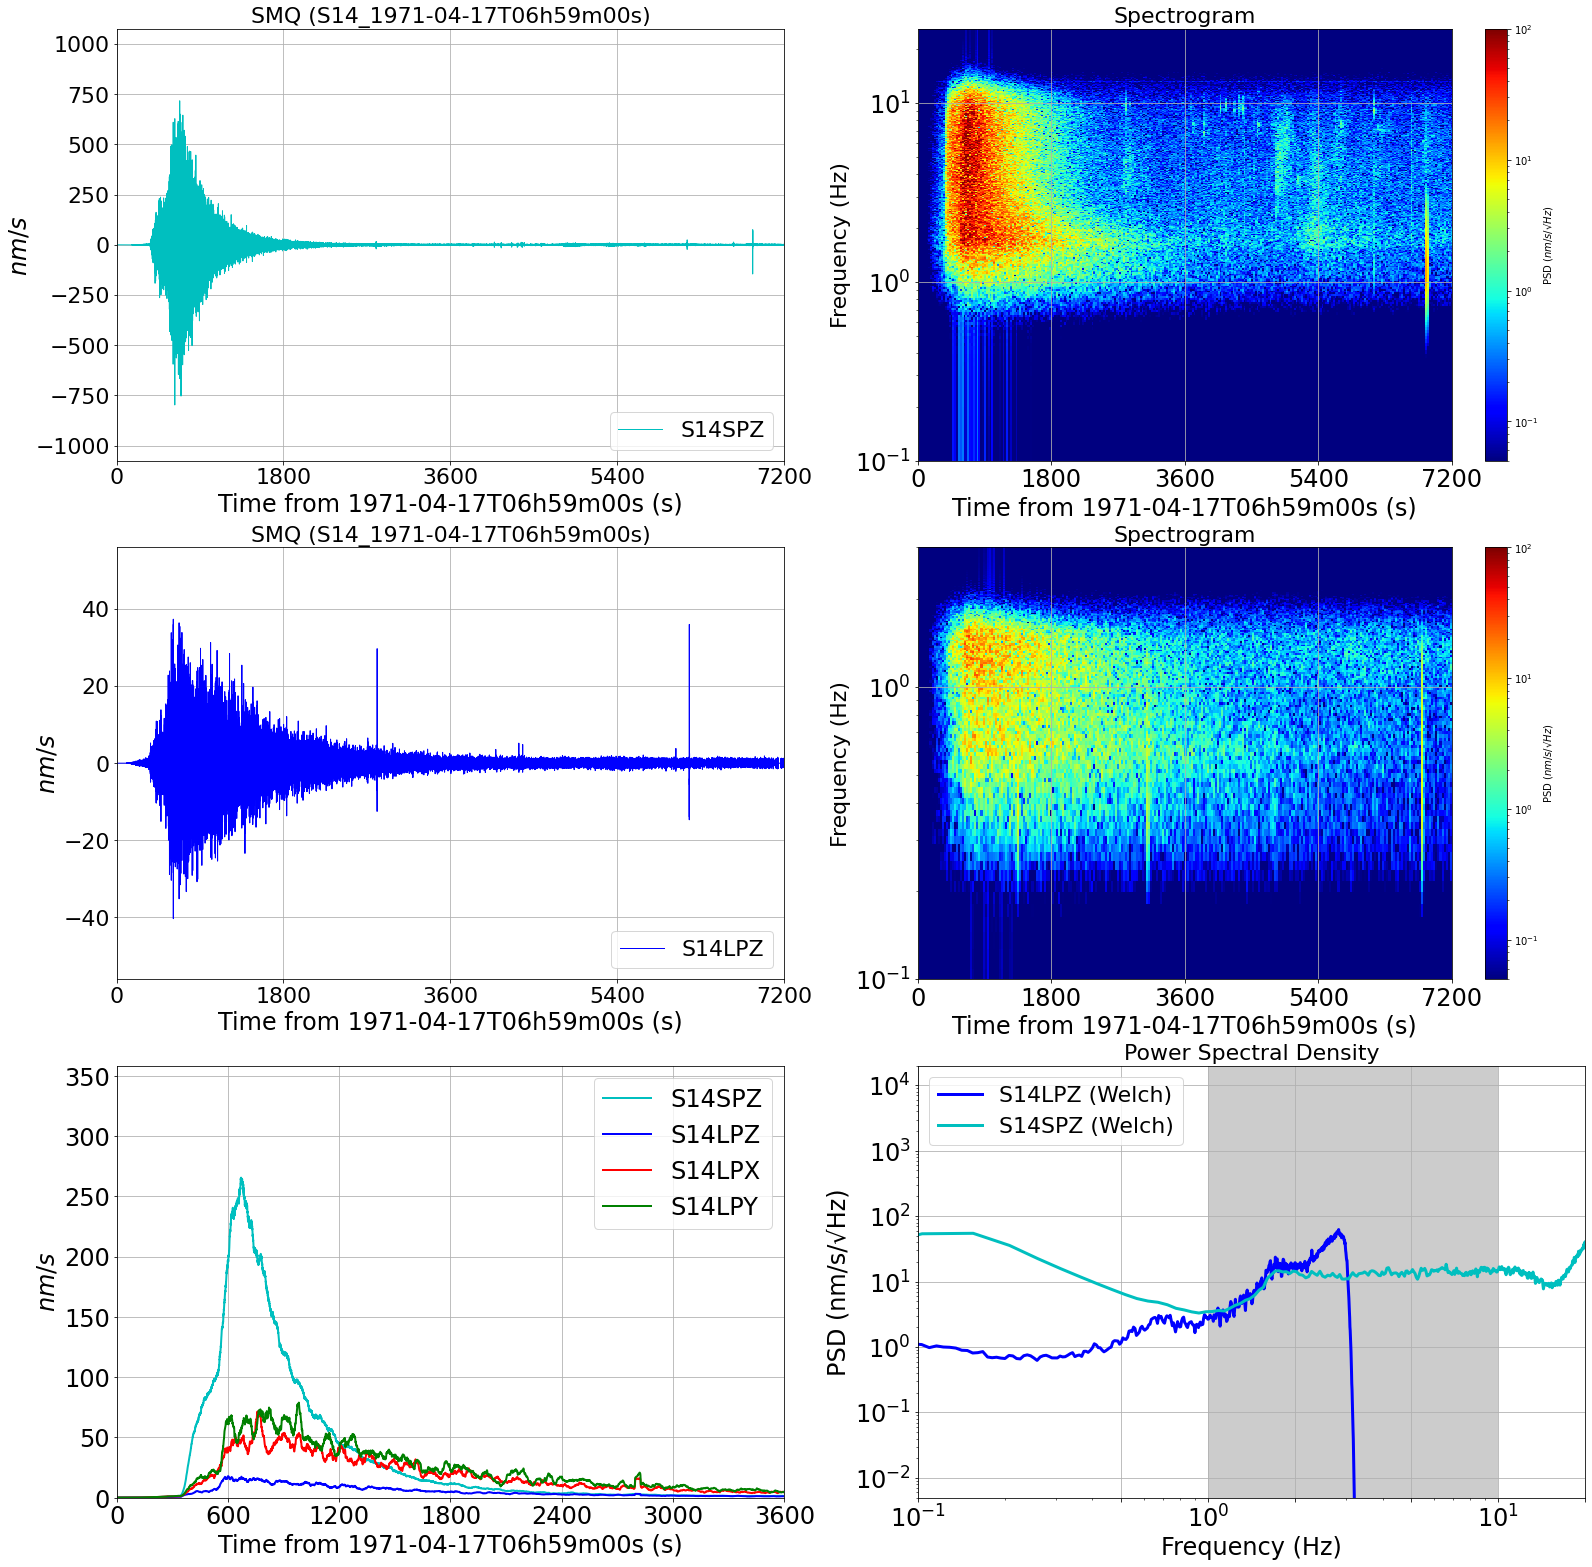

In [8]:
print("############# Plot (SP) #################")
print("Waveform in nm/s")
fig = plt.figure(figsize=(24,24))
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)
t_NI_SP = np.linspace(0, st_NI1_spz[0].data.size*1/f_sp, st_NI1_spz[0].data.size)
ax = fig.add_subplot(3, 2, 1)
plt.title(title, fontsize=font)
ax.plot(t_NI_SP, st_NI1_spz[0].data*1e9, "c-", label = label_sp, linewidth=1.0)
ax.set_ylabel(ylabel, fontsize=font+2)
ax.set_xlabel(xlabel, fontsize=font+2)
plt.grid()
plt.tick_params(labelsize=font)
plt.legend(fontsize=font, loc=loc_legend)
ax.set_ylim(-1.5*np.max(st_NI1_spz[0].data*1e9), 1.5*np.max(st_NI1_spz[0].data*1e9))
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])
ax = fig.add_subplot(3, 2, 3)
plt.title(title, fontsize=font)
ax.plot(t_NI_LP, st_NI1_lpz[0].data*1e9, "b-", label = label_z, linewidth=1.0)
ax.set_ylabel(ylabel, fontsize=font+2)
ax.set_xlabel(xlabel, fontsize=font+2)
plt.grid()
plt.tick_params(labelsize=font)
plt.legend(fontsize=font, loc=loc_legend)
ax.set_ylim(-1.5*np.max(st_NI1_lpz[0].data*1e9), 1.5*np.max(st_NI1_lpz[0].data*1e9))
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])

print("Spectrogram")
ax = fig.add_subplot(3, 2, 2)
plt.title("Spectrogram", fontsize=font)
fx,tx,Sx = signal.spectrogram(st_NI1_spz[0].data*1e9, nfft=int(f_sp*time), nperseg=int(f_sp*time), fs=int(f_sp), noverlap=int(f_sp*time/2), scaling='density',mode='psd', window=('hamming'))
plt.pcolormesh(tx,fx,np.sqrt(Sx), cmap=cmap, norm=colors.LogNorm(vmin=psd_min, vmax=psd_max/2))
ax.set_ylabel("Frequency (Hz)", fontsize=font)
ax.set_xlabel(xlabel, fontsize=font+2)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])
ax.set_ylim(0.1, 26)
ax.set_yticks([0.1,0.5, 1.0, 5.0, 10, 20])
plt.tick_params(labelsize=font+2)
ax.set_yscale("log")
plt.colorbar(orientation ='vertical', label='PSD ($nm/s/√Hz$)')
plt.grid(which='major')
ax = fig.add_subplot(3, 2, 4)
plt.title("Spectrogram", fontsize=font)
fx,tx,Sx = signal.spectrogram(st_NI1_lpz[0].data*1e9, nfft=int(f_lp*time), nperseg=int(f_lp*time), fs=int(f_lp), noverlap=int(f_lp*time/2), scaling='density',mode='psd', window=('hamming'))
plt.pcolormesh(tx,fx,np.sqrt(Sx), cmap=cmap, norm=colors.LogNorm(vmin=psd_min, vmax=psd_max/2))
ax.set_ylabel("Frequency (Hz)", fontsize=font)
ax.set_xlabel(xlabel, fontsize=font+2)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])
ax.set_ylim(0.1, 3)
ax.set_yticks([0.1,0.5, 1.0, 2.0])
plt.tick_params(labelsize=font+2)
ax.set_yscale("log")
plt.colorbar(orientation ='vertical', label='PSD ($nm/s/√Hz$)')
plt.grid(which='major')


print("Power Spectral Density in nm/s/√Hz")
ax = fig.add_subplot(3, 2, 6)
plt.title("Power Spectral Density", fontsize=font)
plt.axvspan(freq_low_sp, freq_high_sp, color='grey', alpha=0.4, lw=0)
#fz, Pz = signal.periodogram(st_NI1_lpz_PSD*1e9, f_lp)
#plt.plot(fz, np.sqrt(Pz), "b-", linewidth=1.0,label=label_z) 
#fsp, Psp = signal.periodogram(st_NI1_spz_PSD*1e9, f_sp)
#plt.plot(fsp, np.abs(Psp), "c-", linewidth=1.0,label=label_sp)
fz_wl, Pz_wl = signal.welch(st_NI1_lpz_PSD*1e9, f_lp , nperseg=1024, noverlap=512, scaling='density', average='mean')
plt.plot(fz_wl, np.sqrt(Pz_wl), "b-", linewidth=3.0,label="S14LPZ (Welch)")
fx_wl, Px_wl = signal.welch(st_NI1_spz_PSD*1e9, f_sp, nperseg=1024, noverlap=512, scaling='density', average='mean') 
plt.plot(fx_wl, np.sqrt(Px_wl), "c-", linewidth=3.0,label="S14SPZ (Welch)")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-1, 20)
ax.set_xticks([0.1,0.5, 1.0, 2.0, 5.0, 10, 20])
plt.tick_params(labelsize=font+2)
ax.set_ylim(psd_min*1e-1, psd_max*1e2)
ax.set_xlabel('Frequency (Hz)', fontsize=font+2)
ax.set_ylabel('PSD (nm/s/√Hz)', fontsize=font+2)
plt.legend(fontsize=font, loc='upper left')
plt.grid()

print("Envelope")
ax = fig.add_subplot(3, 2, 5)
#plt.plot(t_NI_SP, np.abs(st_NI1_spz[0].data*1e9), "c-", label = label_sp, linewidth=2.0)
plt.plot(t_NI_SP, Mv_NI1_spz, "c-", label = label_sp, linewidth=2.0)
plt.plot(t_NI_LP, Mv_NI1_lpz, "b-", label = label_z, linewidth=2.0)
plt.plot(t_NI_LP, Mv_NI1_lpx, "r-", label = label_x, linewidth=2.0)
plt.plot(t_NI_LP, Mv_NI1_lpy, "g-", label = label_y, linewidth=2.0)
ax.set_xlim(0, 3600)
ax.set_ylim(0, np.max(st_NI1_spz[0].data*1e9)*0.5)
plt.tick_params(labelsize=font+2)
ax.set_xticks([0,600,1200,1800, 2400, 3000, 3600])
ax.set_xlabel(xlabel, fontsize=font+2)
ax.set_ylabel("$nm/s$", fontsize=font+2)
plt.legend(fontsize=font+2, loc='upper right')
plt.grid()
plt.show()

############# Plot (SP: DU) #################


<ipython-input-9-5fdf79ca5c67>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(tz,fz,np.sqrt(Sz), cmap=cmap, norm=colors.LogNorm(vmin=psd_min_DU, vmax=psd_max_DU))
<ipython-input-9-5fdf79ca5c67>:33: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(SP_f, (Resp_SP/np.sqrt(SP_f))*psd_max_DU/2, 'k--', linewidth=2.0,label='Apollo-SP')
<ipython-input-9-5fdf79ca5c67>:34: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(AP_f, (Resp_Peak/np.sqrt(AP_f))*psd_max_DU/2, 'c--', linewidth=2.0,label='Apollo-LP')


Envelope


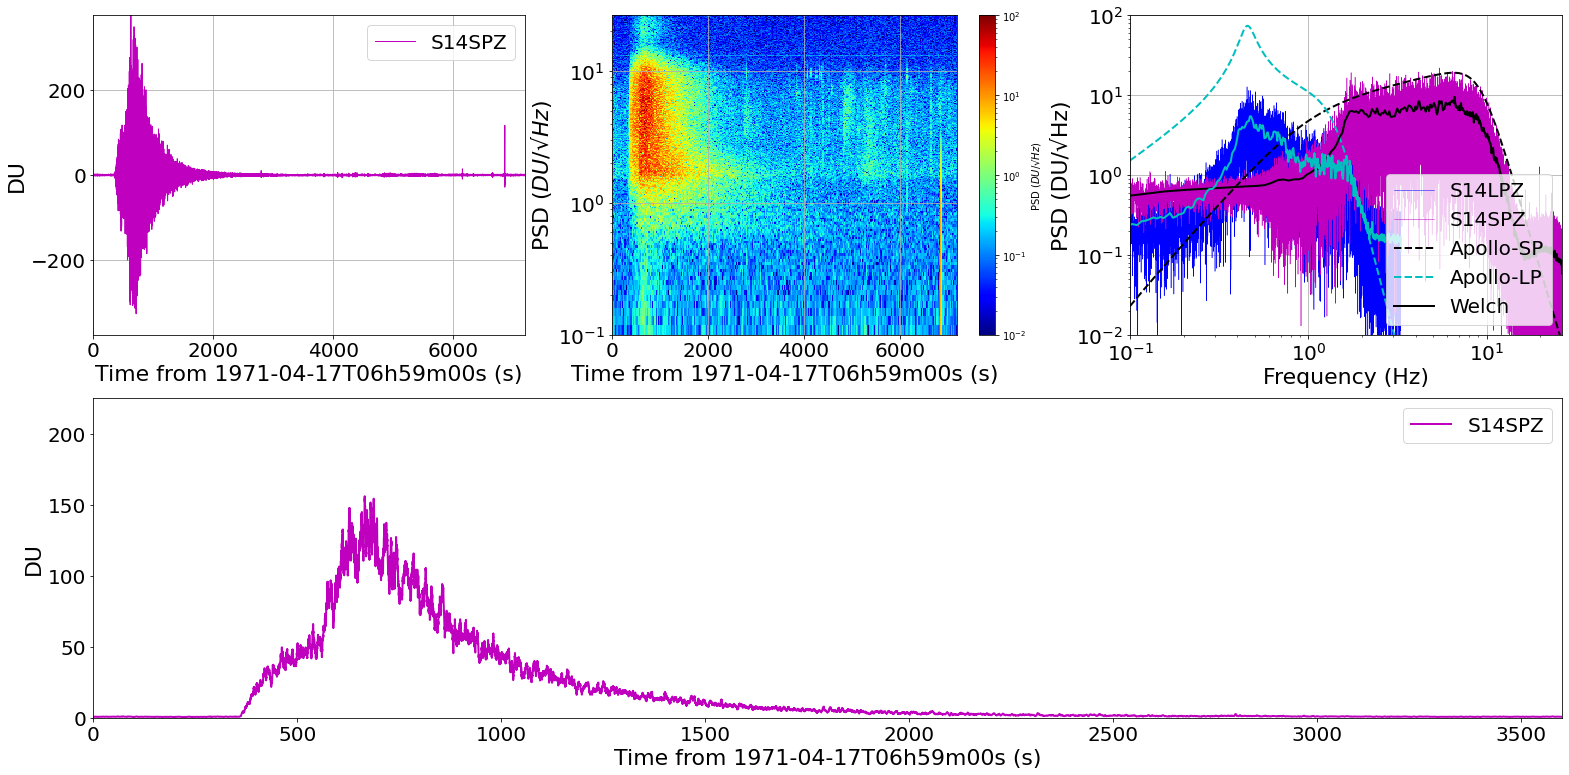

In [9]:
print("############# Plot (SP: DU) #################")
fig = plt.figure(figsize=(24,24))
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)
ax = fig.add_subplot(4, 3, 7)
ax.plot(t_NI_SP, DU_spz[0].data, "m-", label = label_sp, linewidth=1.0)
ax.set_ylabel("DU", fontsize=font)
ax.set_xlabel(xlabel, fontsize=font)
plt.grid()
plt.tick_params(labelsize=font-2)
plt.legend(fontsize=font-2, loc='upper right')
ax.set_ylim(-2.5*DUmax, 2.5*DUmax)
ax.set_xlim(0, 7200)

ax = fig.add_subplot(4, 3, 8)
fz,tz,Sz = signal.spectrogram(DU_spz[0].data, nfft=int(f_sp*time), nperseg=int(f_sp*time), fs=int(f_sp), noverlap=int(f_sp*time/2), scaling='density',mode='psd', window=('hamming'))
plt.pcolormesh(tz,fz,np.sqrt(Sz), cmap=cmap, norm=colors.LogNorm(vmin=psd_min_DU, vmax=psd_max_DU))
ax.set_ylabel("Frequency (Hz)", fontsize=font)
ax.set_xlim(0, 7200)
ax.set_ylim(0.1, f_sp/2)
plt.tick_params(labelsize=font-2)
ax.set_yscale("log")
plt.colorbar(orientation ='vertical', label='PSD ($DU/√Hz$)')
plt.grid(which='major')
ax.set_ylabel('PSD ($DU/√Hz$)')
ax.set_xlabel(xlabel, fontsize=font)

ax = fig.add_subplot(4, 3, 9)
#plt.axvspan(freq_low, freq_high, color='grey', alpha=0.4, lw=0)
fz, Pz = signal.periodogram(DU_lpz_PSD, f_lp)
plt.plot(fz, np.sqrt(Pz), "b-", linewidth=0.5,label=label_z)
fz, Pz = signal.periodogram(DU_spz_PSD, f_sp)
plt.plot(fz, np.sqrt(Pz), "m-", linewidth=0.5,label=label_sp)
plt.plot(SP_f, (Resp_SP/np.sqrt(SP_f))*psd_max_DU/2, 'k--', linewidth=2.0,label='Apollo-SP')
plt.plot(AP_f, (Resp_Peak/np.sqrt(AP_f))*psd_max_DU/2, 'c--', linewidth=2.0,label='Apollo-LP')
fz_wl, Pz_wl = signal.welch(DU_spz_PSD, f_sp , nperseg=1024, noverlap=512, scaling='density', average='mean') 
plt.plot(fz_wl, np.sqrt(Pz_wl), "k-", linewidth=2.0,label="Welch")
fz_wl, Pz_wl = signal.welch(DU_lpz_PSD, f_lp , nperseg=1024, noverlap=512, scaling='density', average='mean') 
plt.plot(fz_wl, np.sqrt(Pz_wl), "c-", linewidth=2.0)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-1, f_sp/2)
plt.tick_params(labelsize=font-2)
ax.set_ylim(psd_min_DU, psd_max_DU)
ax.set_xlabel('Frequency (Hz)', fontsize=font)
ax.set_ylabel('PSD (DU/√Hz)', fontsize=font)
plt.legend(fontsize=font-2, loc=loc_legend)
plt.grid()

print("Envelope")
ax = fig.add_subplot(4, 1, 4)
ax.plot(t_NI_SP, Mv_DU_spz, "m-", label = label_sp, linewidth=2.0)
ax.set_xlim(0, 3600)
ax.set_ylim(0, DUmax*1.5)
plt.tick_params(labelsize=font-2)
ax.set_xlabel(xlabel, fontsize=font)
ax.set_ylabel("DU", fontsize=font)
plt.legend(fontsize=font-2, loc="upper right")

plt.show()

# SMQ_710520

In [252]:
# Input parameters
Sta="S14"
Event="SMQ"
start_time="1971-05-20T17h24m00s"
title=Event+" ("+Sta+"_"+start_time+"_LP)"

Dir_data="./dataset/SMQ_710520/"+Sta

name_fig1="./"+Event+"_VEL_"+Sta+"_"+start_time+"_LP.png"
name_fig2="./"+Event+"_DU_"+Sta+"_"+start_time+"_LP.png"
name_fig3="./"+Event+"_VEL_"+Sta+"_"+start_time+"_SP.png"
name_fig4="./"+Event+"_DU_"+Sta+"_"+start_time+"_SP.png"

output_file_z="./ppsd/ppsd_sac_ACCz_"+Event+"_"+Sta+".png"
output_file_x="./ppsd/ppsd_sac_ACCx_"+Event+"_"+Sta+".png"
output_file_y="./ppsd/ppsd_sac_ACCy_"+Event+"_"+Sta+".png"

xlabel ="Time from "+start_time+" (s)"
ylabel ="$nm/s$"
label_z = Sta+"LPZ"
label_x = Sta+"LPX"
label_y = Sta+"LPY"
label_sp = Sta+"SPZ"

ymax = 40
psd_max=2e2
psd_min=5e-2

DUmax = 150
psd_max_DU=1e2
psd_min_DU=1e-2

## Bandpass (LP)
freq_low=0.3
freq_high=1.5
pre_low=0.05 #used for prefiltering
pre_high=3.0 #used for prefiltering
## Bandpass (SP)
freq_low_sp=1.0
freq_high_sp=10.0
pre_low_sp=0.1 #used for prefiltering
pre_high_sp=26.0 #used for prefiltering



vmax = psd_max/2
vmin = psd_min
cmap = plt.get_cmap("jet", lut = 300)

num_mv_Apo = 200 ## The number of samples used for moving average
font = 22
time=50 ## time width for spectrogram f_lp*time (s)
loc_legend='lower right'
##############################################################


print("################# Read Apollo Seismic Data ###################")
st_NI1_lpz = read(Dir_data+"/SMQ_LPZ.sac") 
st_NI1_lpx = read(Dir_data+"/SMQ_LPX.sac") 
st_NI1_lpy = read(Dir_data+"/SMQ_LPY.sac") 
st_NI1_spz = read(Dir_data+"/SMQ_SPZ.sac") 
DU_lpz=st_NI1_lpz.copy()
DU_lpx=st_NI1_lpx.copy()
DU_lpy=st_NI1_lpy.copy()
DU_spz=st_NI1_spz.copy()

f_lp = 6.6 ## Sampling rate
f_sp = 53 ## Sampling rate
N = st_NI1_lpz[0].data.size
N_sp=st_NI1_spz[0].data.size
########## Apollo response curve ##############
LP_t_samp=1/f_lp #sec
LP_nfft = N #Sample Number of Simulation output
SP_t_samp=1/f_sp #sec
SP_nfft = N_sp #Sample Number of Simulation output

#Convert Poles and Zeros to Frequency Response (LP Flat)
AF_scale_fac = 5.18524045674722E+18
AF_zeros = [-9.97000000000000E-04 -0.00000000000000E+00j, 0.00000000000000E+00 + 0.00000000000000E+00j, 0.00000000000000E+00 + 0.00000000000000E+00j, 0.00000000000000E+00 + 0.00000000000000E+00j]
AF_poles = [-6.28000000000000E-02 + 0.00000000000000E+00j, -4.76199964295322E+01 + 0.00000000000000E+00j, -5.94194170468653E-02 + 0.00000000000000E+00j, -3.26855546475662E-01 + -1.74189592000858E-01j, -3.26855546475662E-01 + 1.74189592000858E-01j, -3.33954437504881E+00 -8.06237332238962E+00j, -3.33954437504881E+00 + 8.06237332238962E+00j, -3.33954437504881E+00 -8.06237332238962E+00j, -3.33954437504881E+00 + 8.06237332238962E+00j, -8.06237332238962E+00 -3.33954437504881E+00j, -8.06237332238962E+00 + 3.33954437504881E+00j, -8.06237332238962E+00 -3.33954437504881E+00j, -8.06237332238962E+00 + 3.33954437504881E+00j]
AF_h, AF_f=paz_to_freq_resp(AF_poles, AF_zeros, AF_scale_fac, LP_t_samp, LP_nfft, freq=True)
#Convert Poles and Zeros to Frequency Response (LP Peak)
AP_scale_fac = 5.18524045674722E+18
AP_zeros = [0.00000000000000E+00 + 0.00000000000000E+00j, 0.00000000000000E+00 + 0.00000000000000E+00j, 0.00000000000000E+00 + 0.00000000000000E+00j]
AP_poles = [-6.28000000000000E-02 + 0.00000000000000E+00j, -4.77893183981691E+01 + 0.00000000000000E+00j, -2.71405770680666E-01 -2.84127616186138E+00j, -2.71405770680666E-01 + 2.84127616186138E+00j, -3.33954437504881E+00 -8.06237332238962E+00j, -3.33954437504881E+00 + 8.06237332238962E+00j, -3.33954437504881E+00 -8.06237332238962E+00j, -3.33954437504881E+00 + 8.06237332238962E+00j, -8.06237332238962E+00 -3.33954437504881E+00j, -8.06237332238962E+00 + 3.33954437504881E+00j, -8.06237332238962E+00 -3.33954437504881E+00j, -8.06237332238962E+00 + 3.33954437504881E+00j]
AP_h, AP_f=paz_to_freq_resp(AP_poles, AP_zeros, AP_scale_fac, LP_t_samp, LP_nfft, freq=True)
#Convert Poles and Zeros to Frequency Response (LP Tidal)
SP_scale_fac = 5.76082444429034E+22
SP_zeros = [0.0 + 0.0j,0.0 + 0.0j,0.0 + 0.0j,0.0 + 0.0j]
SP_poles = [-5.34070751110265E+00 + 3.30987324307279E+00j,-5.34070751110265E+00 - 3.30987324307279E+00j,-0.31416000000000E+00 + 0.00000000000000E+00j,-5.27719065090915E+01 + 2.18588393883507E+01j,-5.27719065090915E+01 + 2.18588393883507E+01j,-5.27719065090915E+01 - 2.18588393883507E+01j,-5.27719065090915E+01 - 2.18588393883507E+01j,-2.18588393883507E+01 + 5.27719065090915E+01j,-2.18588393883507E+01 + 5.27719065090915E+01j,-2.18588393883507E+01 - 5.27719065090915E+01j,-2.18588393883507E+01 - 5.27719065090915E+01j]
SP_h, SP_f = paz_to_freq_resp(SP_poles, SP_zeros, SP_scale_fac, SP_t_samp, SP_nfft, freq=True)
################## Seismometer Correction #########################
AF_A0 = 1735742164.9349701 # gain
AF_Ds = 3736331684.7959046 # Sensitivity
AP_A0 = 1387789118.8962953 # gain
AP_Ds = 2987333350.251064  # Sensitivity
#TD_A0 = 4.81281409448854E+01
#TD_Ds = ???
SP_A0 = 5695016579508.034 # gain
SP_Ds = 10115553420.896257 # Sensitivity
paz_AF = {'poles': AF_poles,'zeros': AF_zeros,'gain': AF_A0,'sensitivity': AF_Ds}
paz_AP = {'poles': AP_poles,'zeros': AP_zeros,'gain': AP_A0,'sensitivity': AP_Ds}
paz_SP = {'poles': SP_poles,'zeros': SP_zeros,'gain': SP_A0,'sensitivity': SP_Ds}
###################################################################

print("############ Probabilistic PSD (ACC) ###################")



###################################################################
print("############# Analysis Wave Data #################")
### Convert into Physical Value
print("LPZ")
st_NI1_lpz.detrend('demean') #rmean
st_NI1_lpz.detrend(type='linear') #detrend
st_NI1_lpz.taper(0.05,type='cosine')
st_NI1_lpz.filter('lowpass', freq=pre_high, zerophase=True)
st_NI1_lpz.filter('highpass', freq=pre_low, zerophase=True)

################# Read Apollo Seismic Data ###################
############ Probabilistic PSD (ACC) ###################
############# Analysis Wave Data #################
LPZ


1 Trace(s) in Stream:
XA.S14..LPZ | 1971-05-20T17:23:59.969849Z - 1971-05-20T20:28:59.894377Z | 6.6 Hz, 73538 samples

In [253]:
from copy import deepcopy
import pandas as pd
data = deepcopy(st_NI1_lpx[0].data)

data = Series(data)

def plot_outlier(ts, span_mean=1000, span_std=10000, threshold=3.0):
    assert type(ts) == pd.Series
    ret_ts = ts.copy()
    for _ in [0]*5:
        fig, ax = plt.subplots(figsize=(24, 8))

        ewm_mean = ret_ts.ewm(span=span_mean).mean()  # 指数加重移動平均
        ewm_std = ret_ts.ewm(span=span_std).std()  # 指数加重移動標準偏差
        ax.plot(ret_ts, label='original', color='blue')
        ax.plot(ewm_mean, label='ewma', color='green')

        # 標準偏差から 3.0 倍以上外れているデータを外れ値としてプロットする
        ax.fill_between(ret_ts.index,
                        ewm_mean - ewm_std * threshold,
                        ewm_mean + ewm_std * threshold,
                        alpha=0.2)
        outlier = ret_ts[(ret_ts - ewm_mean).abs() > ewm_std * threshold]
        ax.scatter(outlier.index, outlier, label='outlier', color='red')

        ax.legend()
        plt.show()

        ret_ts[outlier.index] = ewm_mean[outlier.index]
    return ret_ts

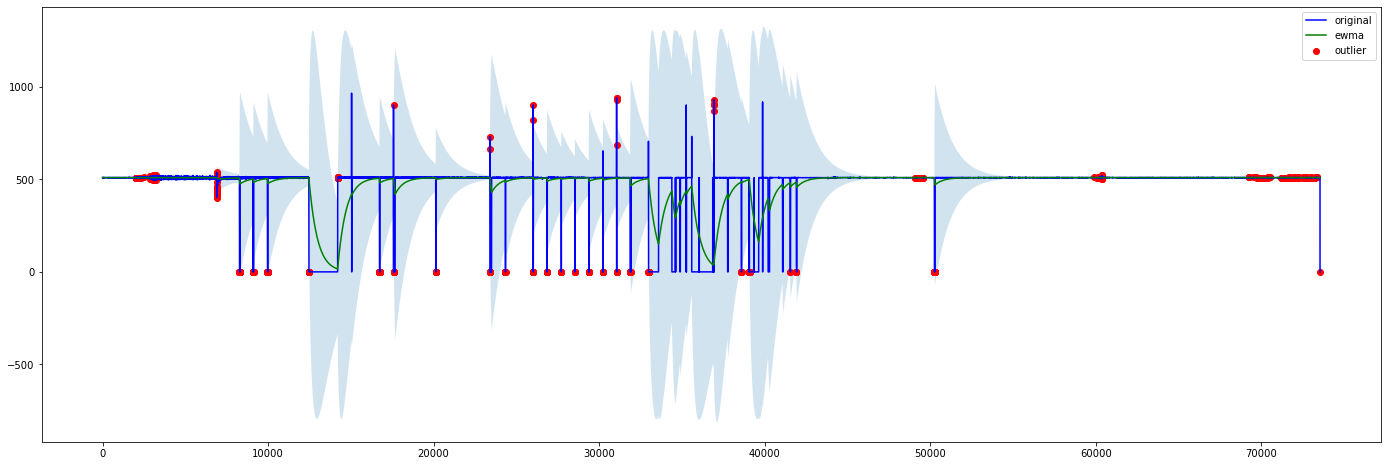

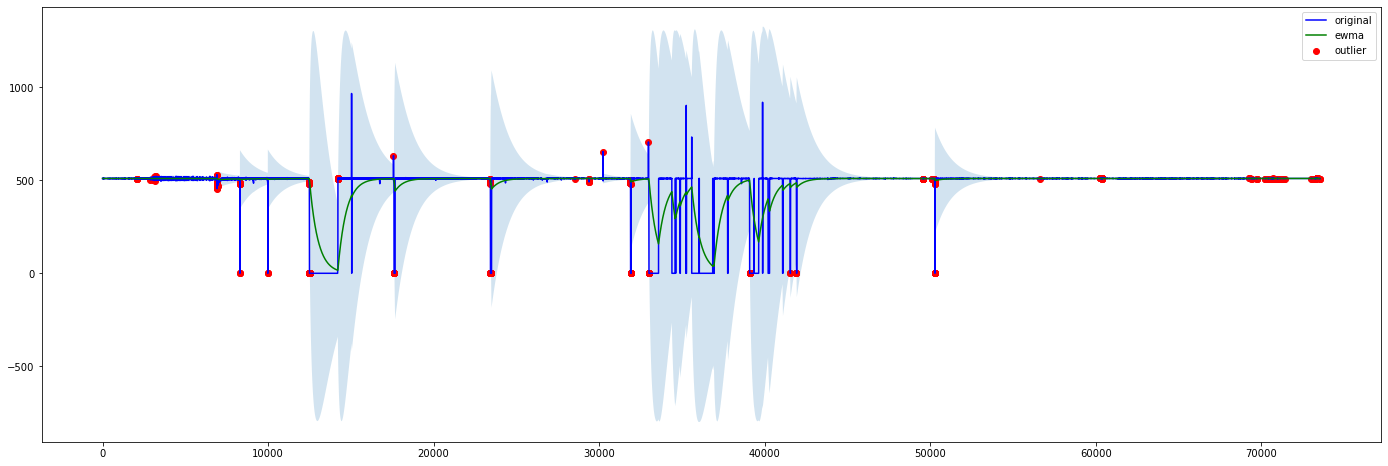

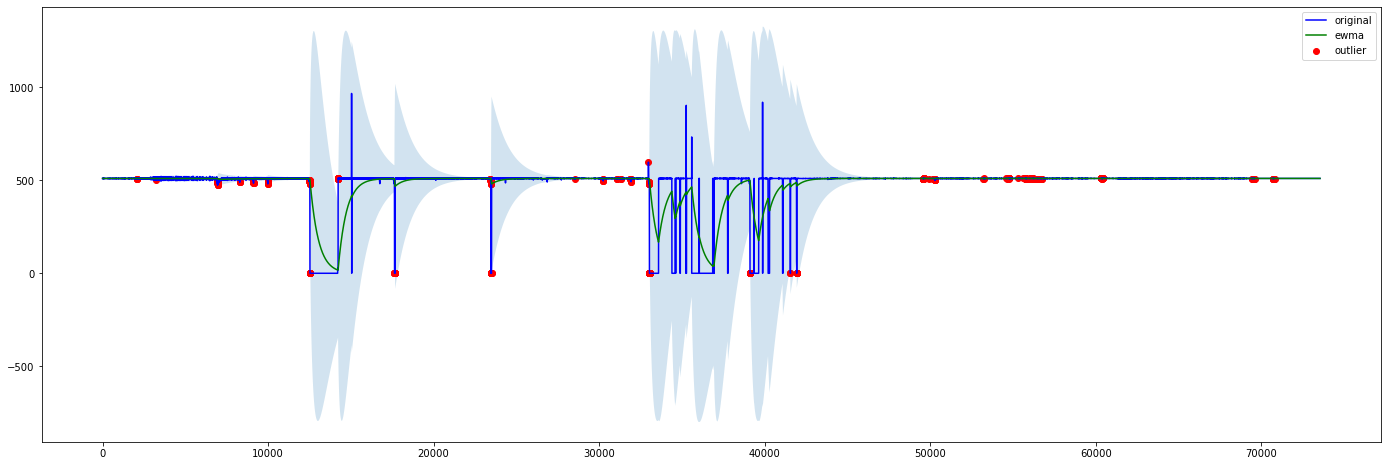

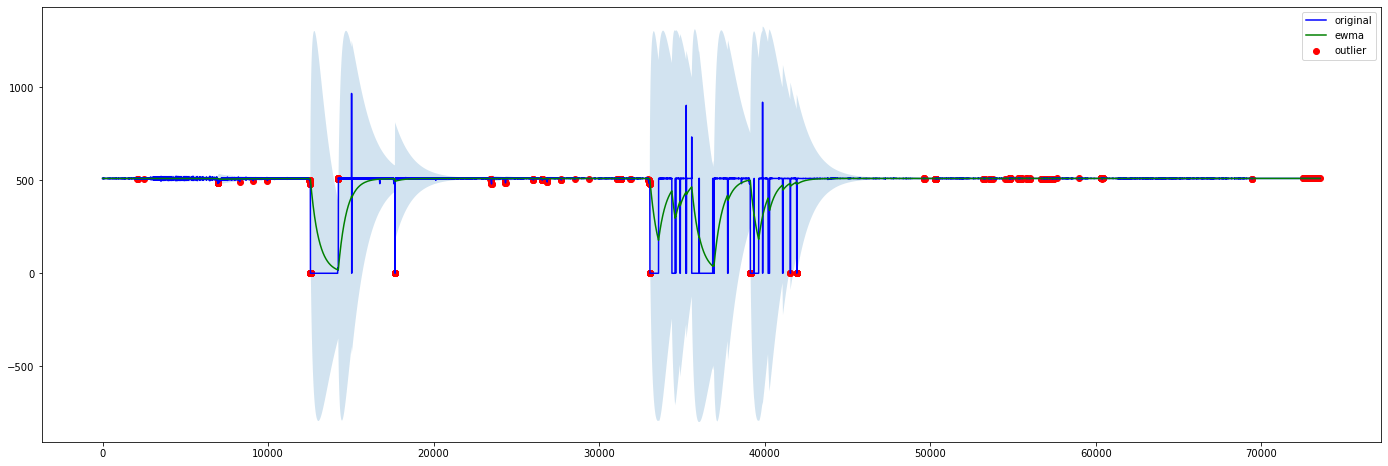

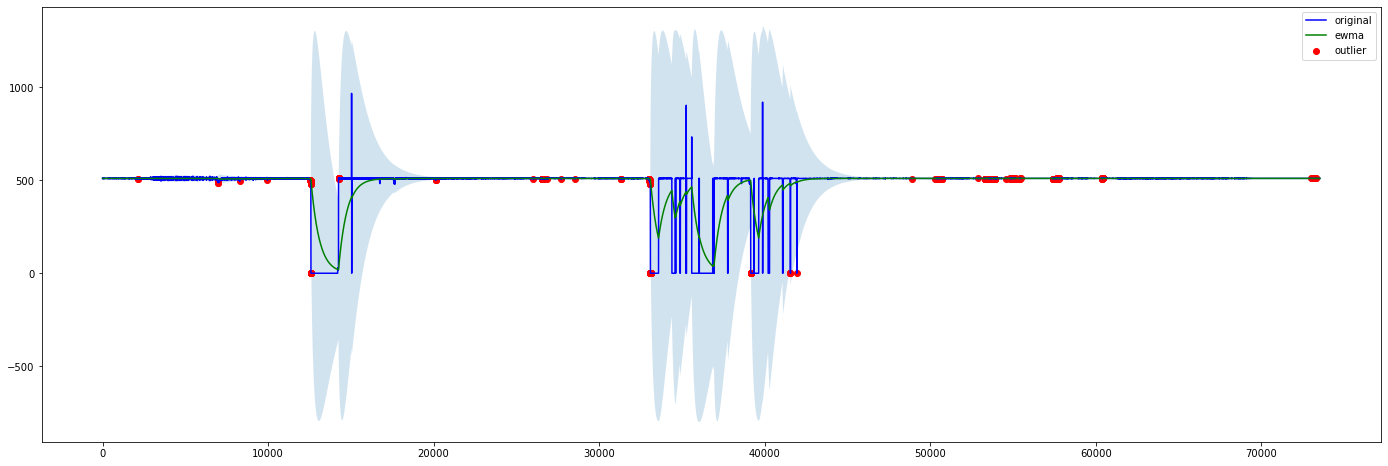

In [254]:
aaa = plot_outlier(data, 1000, 1000, 4)

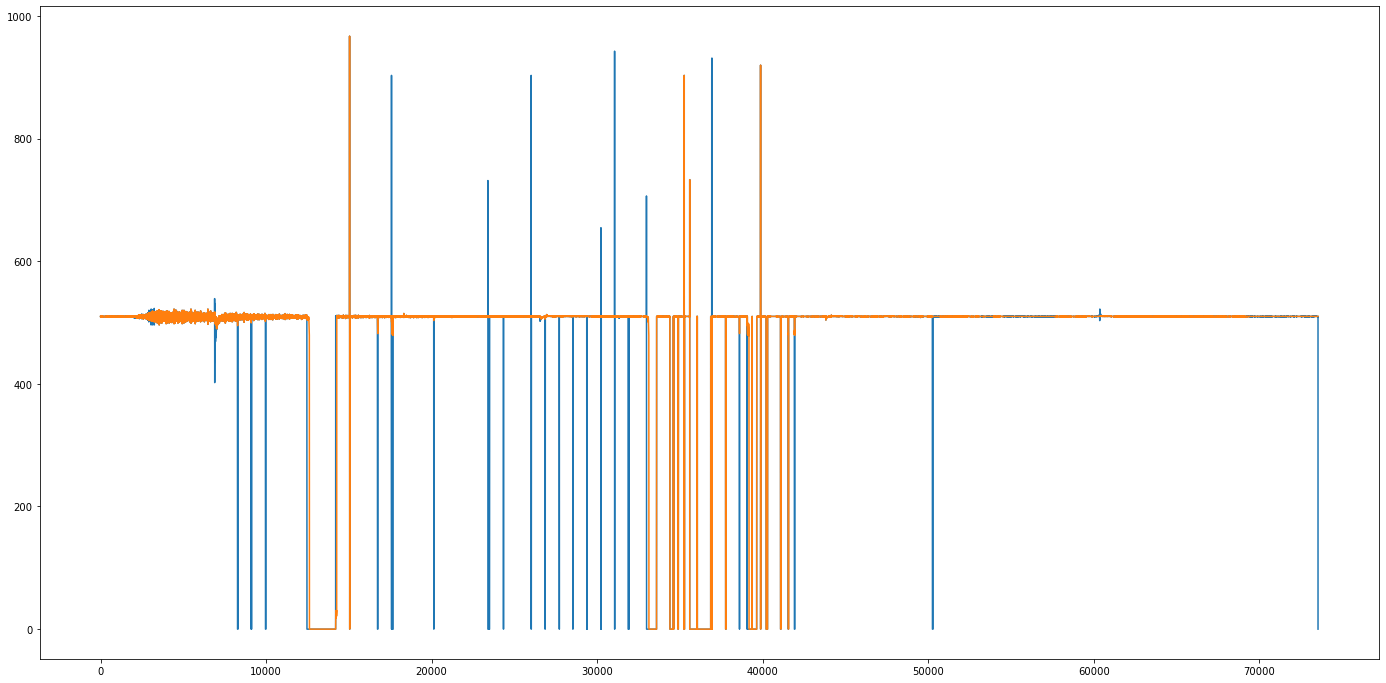

In [255]:
plt.figure(figsize=(24, 12))
data.plot()
aaa.plot()
plt.show()

<AxesSubplot:>

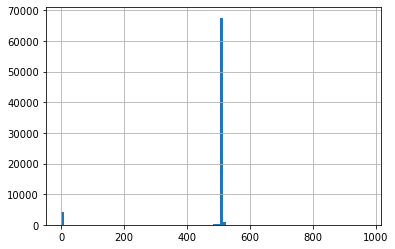

In [234]:
aaa.hist(bins=100)

In [225]:
st_NI1_lpz.simulate(paz_remove=paz_AP) # Remove response
st_NI1_lpz.taper(0.05,type='cosine')
st_NI1_lpz.differentiate(method='gradient')
st_NI1_lpz_PSD=st_NI1_lpz[0].data
st_NI1_lpz.filter('lowpass', freq=freq_high, zerophase=True)
st_NI1_lpz.filter('highpass', freq=freq_low, zerophase=True)

print("LPX")
st_NI1_lpx.detrend('demean') #rmean
st_NI1_lpx.detrend(type='linear') #detrend
st_NI1_lpx.taper(0.05,type='cosine')
st_NI1_lpx.filter('lowpass', freq=pre_high, zerophase=True)
st_NI1_lpx.filter('highpass', freq=pre_low, zerophase=True)
st_NI1_lpx.simulate(paz_remove=paz_AP) # Remove response
st_NI1_lpx.taper(0.05,type='cosine')
st_NI1_lpx.differentiate(method='gradient')
st_NI1_lpx_PSD=st_NI1_lpx[0].data
st_NI1_lpx.filter('lowpass', freq=freq_high, zerophase=True)
st_NI1_lpx.filter('highpass', freq=freq_low, zerophase=True)

print("LPY")
st_NI1_lpy.detrend('demean') #rmean
st_NI1_lpy.detrend(type='linear') #detrend
st_NI1_lpy.taper(0.05,type='cosine')
st_NI1_lpy.filter('lowpass', freq=pre_high, zerophase=True)
st_NI1_lpy.filter('highpass', freq=pre_low, zerophase=True)
st_NI1_lpy.simulate(paz_remove=paz_AP) # Remove response
st_NI1_lpy.taper(0.05,type='cosine')
st_NI1_lpy.differentiate(method='gradient')
st_NI1_lpy_PSD=st_NI1_lpy[0].data
st_NI1_lpy.filter('lowpass', freq=freq_high, zerophase=True)
st_NI1_lpy.filter('highpass', freq=freq_low, zerophase=True)

print("SPZ")
st_NI1_spz.detrend('demean') #rmean
st_NI1_spz.detrend(type='linear') #detrend
st_NI1_spz.taper(0.05,type='cosine')
st_NI1_spz.filter('lowpass', freq=pre_high_sp, zerophase=True)
st_NI1_spz.filter('highpass', freq=pre_low_sp, zerophase=True)
st_NI1_spz.simulate(paz_remove=paz_SP) # Remove response
st_NI1_spz.taper(0.05,type='cosine')
st_NI1_spz.differentiate(method='gradient')
st_NI1_spz_PSD=st_NI1_spz[0].data
st_NI1_spz.filter('lowpass', freq=freq_high_sp, zerophase=True)
st_NI1_spz.filter('highpass', freq=freq_low_sp, zerophase=True)

### Envelope (VEL)
Env_st_NI1_lpz=obspy.signal.filter.envelope(st_NI1_lpz[0].data*1e9)
Env_st_NI1_lpx=obspy.signal.filter.envelope(st_NI1_lpx[0].data*1e9)
Env_st_NI1_lpy=obspy.signal.filter.envelope(st_NI1_lpy[0].data*1e9)
Env_st_NI1_spz=obspy.signal.filter.envelope(st_NI1_spz[0].data*1e9)

### Moving Average
b = np.ones(num_mv_Apo)/num_mv_Apo
b_s = np.ones(int(num_mv_Apo*10))/int(num_mv_Apo*10)
Mv_NI1_lpz = np.convolve(Env_st_NI1_lpz, b, mode='same') ## Moving Average (nm/s)
Mv_NI1_lpx = np.convolve(Env_st_NI1_lpx, b, mode='same') ## Moving Average (nm/s)
Mv_NI1_lpy = np.convolve(Env_st_NI1_lpy, b, mode='same') ## Moving Average (nm/s)
Mv_NI1_spz = np.convolve(Env_st_NI1_spz, b_s, mode='same') ## Moving Average (nm/s)

LPX
LPY
SPZ


############# Plot #################
Waveform in nm/s
Envelope
Power Spectral Density in nm/s/√Hz
Spectrogram


<ipython-input-13-f364de33d658>:101: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(tx,fx,np.sqrt(Sx), cmap=cmap, norm=colors.LogNorm(vmin=psd_min, vmax=psd_max/2))
<ipython-input-13-f364de33d658>:113: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(ty,fy,np.sqrt(Sy), cmap=cmap, norm=colors.LogNorm(vmin=psd_min, vmax=psd_max/2))
<ipython-input-13-f364de33d658>:125: MatplotlibDeprecationWarning: shading='flat' when X and Y have the 

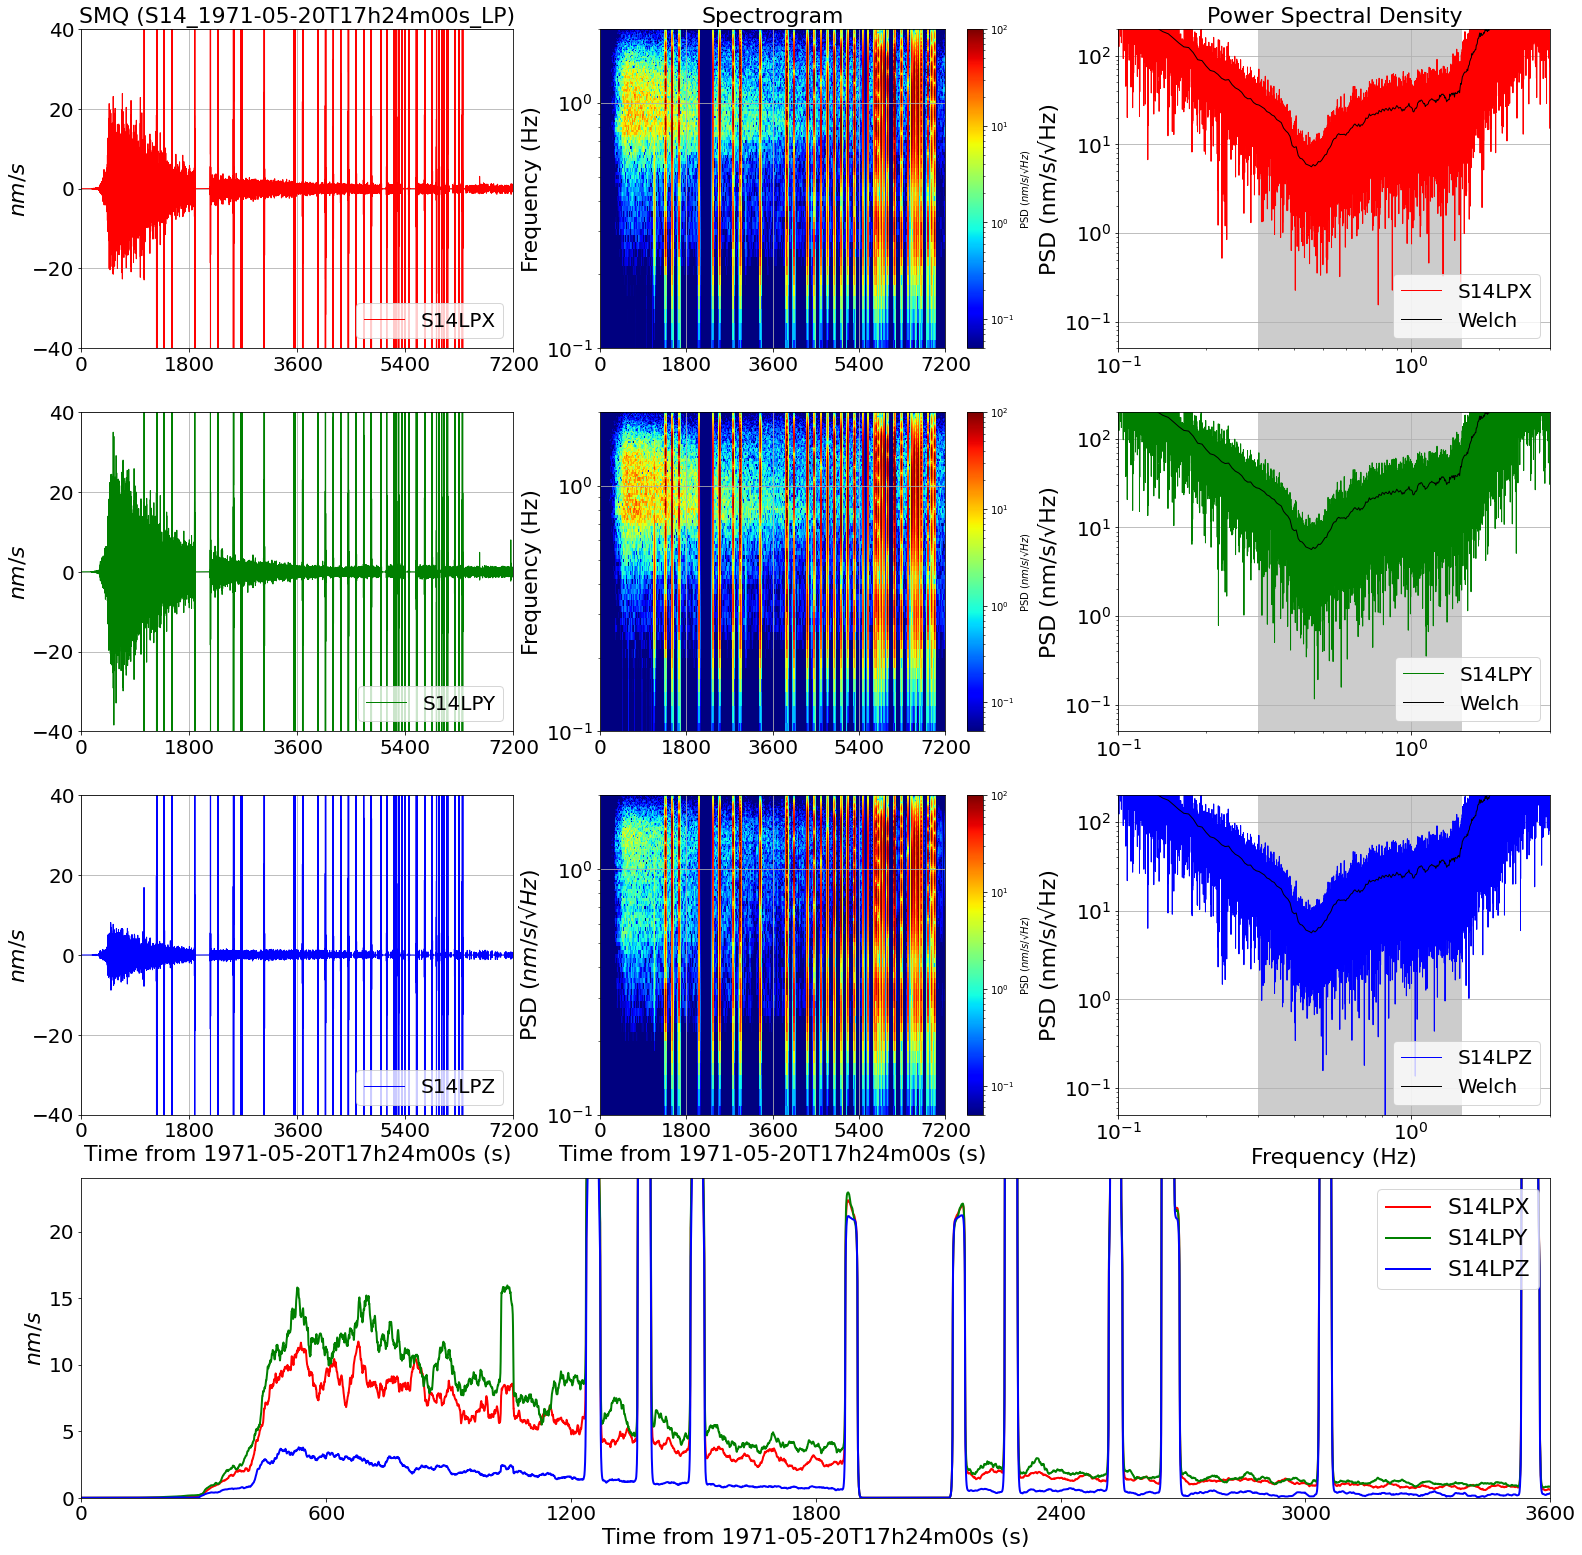

In [13]:
print("############# Plot #################")
print("Waveform in nm/s")
fig = plt.figure(figsize=(24,24))
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)
t_NI_LP = np.linspace(0, st_NI1_lpz[0].data.size*1/f_lp, st_NI1_lpz[0].data.size)
ax = fig.add_subplot(4, 3, 1)
plt.title(title, fontsize=font)
ax.plot(t_NI_LP, st_NI1_lpx[0].data*1e9, "r-", label = label_x, linewidth=1.0)
ax.set_ylabel(ylabel, fontsize=font)
plt.grid()
plt.tick_params(labelsize=font-2)
plt.legend(fontsize=font-2, loc=loc_legend)
ax.set_ylim(-1*ymax, ymax)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])
ax = fig.add_subplot(4, 3, 4)
ax.plot(t_NI_LP, st_NI1_lpy[0].data*1e9, "g-", label = label_y, linewidth=1.0)
ax.set_ylabel(ylabel, fontsize=font)
plt.grid()
plt.tick_params(labelsize=font-2)
plt.legend(fontsize=font-2, loc=loc_legend)
ax.set_ylim(-1*ymax, ymax)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])
ax = fig.add_subplot(4, 3, 7)
ax.plot(t_NI_LP, st_NI1_lpz[0].data*1e9, "b-", label = label_z, linewidth=1.0)
ax.set_ylabel(ylabel, fontsize=font)
ax.set_xlabel(xlabel, fontsize=font)
plt.grid()
plt.tick_params(labelsize=font-2)
plt.legend(fontsize=font-2, loc=loc_legend)
ax.set_ylim(-1*ymax, ymax)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])

print("Envelope")
ax = fig.add_subplot(4, 1, 4)
ax.plot(t_NI_LP, Mv_NI1_lpx, "r-", label = label_x, linewidth=2.0)
ax.plot(t_NI_LP, Mv_NI1_lpy, "g-", label = label_y, linewidth=2.0)
ax.plot(t_NI_LP, Mv_NI1_lpz, "b-", label = label_z, linewidth=2.0)
ax.set_xlim(0, 3600)
ax.set_xticks([0,600,1200,1800, 2400, 3000, 3600])
ax.set_ylim(0, ymax*0.6)
plt.tick_params(labelsize=font-2)
ax.set_xlabel(xlabel, fontsize=font)
ax.set_ylabel("$nm/s$", fontsize=font)
plt.legend(fontsize=font, loc='upper right')

print("Power Spectral Density in nm/s/√Hz")
ax = fig.add_subplot(4, 3, 3)
plt.title("Power Spectral Density", fontsize=font)
plt.axvspan(freq_low, freq_high, color='grey', alpha=0.4, lw=0)
fx, Px = signal.periodogram(st_NI1_lpx_PSD*1e9, f_lp)
plt.plot(fx, np.sqrt(Px), "r-", linewidth=1.0,label=label_x)
fx_wl, Px_wl = signal.welch(st_NI1_lpx_PSD*1e9, f_lp , nperseg=1024, noverlap=512, scaling='density', average='mean') 
plt.plot(fx_wl, np.sqrt(Px_wl), "k-", linewidth=1.0,label="Welch")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-1, 3.0)
plt.tick_params(labelsize=font-2)
ax.set_ylim(psd_min, psd_max)
#ax.set_xlabel('Frequency (Hz)', fontsize=font)
ax.set_ylabel('PSD (nm/s/√Hz)', fontsize=font)
plt.legend(fontsize=font-2, loc=loc_legend)
plt.grid()
ax = fig.add_subplot(4, 3, 6)
plt.axvspan(freq_low, freq_high, color='grey', alpha=0.4, lw=0)
fy, Py = signal.periodogram(st_NI1_lpy_PSD*1e9, f_lp)
plt.plot(fy, np.sqrt(Py), "g-", linewidth=1.0,label=label_y)
fy_wl, Py_wl = signal.welch(st_NI1_lpy_PSD*1e9, f_lp , nperseg=1024, noverlap=512, scaling='density', average='mean') 
plt.plot(fy_wl, np.sqrt(Py_wl), "k-", linewidth=1.0,label="Welch")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-1, 3.0)
plt.tick_params(labelsize=font-2)
ax.set_ylim(psd_min, psd_max)
#ax.set_xlabel('Frequency (Hz)', fontsize=font)
ax.set_ylabel('PSD (nm/s/√Hz)', fontsize=font)
plt.legend(fontsize=font-2, loc=loc_legend)
plt.grid()
ax = fig.add_subplot(4, 3, 9)
plt.axvspan(freq_low, freq_high, color='grey', alpha=0.4, lw=0)
fz, Pz = signal.periodogram(st_NI1_lpz_PSD*1e9, f_lp)
plt.plot(fz, np.sqrt(Pz), "b-", linewidth=1.0,label=label_z)
fz_wl, Pz_wl = signal.welch(st_NI1_lpz_PSD*1e9, f_lp , nperseg=1024, noverlap=512, scaling='density', average='mean') 
plt.plot(fz_wl, np.sqrt(Pz_wl), "k-", linewidth=1.0,label="Welch")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-1, 3.0)
plt.tick_params(labelsize=font-2)
ax.set_ylim(psd_min, psd_max)
ax.set_xlabel('Frequency (Hz)', fontsize=font)
ax.set_ylabel('PSD (nm/s/√Hz)', fontsize=font)
plt.legend(fontsize=font-2, loc=loc_legend)
plt.grid()
print("Spectrogram")
ax = fig.add_subplot(4, 3, 2)
plt.title("Spectrogram", fontsize=font)
fx,tx,Sx = signal.spectrogram(st_NI1_lpx[0].data*1e9, nfft=int(f_lp*time), nperseg=int(f_lp*time), fs=int(f_lp), noverlap=int(f_lp*time-1), scaling='density',mode='psd', window=('hamming'))
#plt.pcolormesh(tx,fx,np.sqrt(Sx), cmap=cmap, norm=colors.LogNorm())
plt.pcolormesh(tx,fx,np.sqrt(Sx), cmap=cmap, norm=colors.LogNorm(vmin=psd_min, vmax=psd_max/2))
ax.set_ylabel("Frequency (Hz)", fontsize=font)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])
ax.set_ylim(0.1, 2.0)
plt.tick_params(labelsize=font-2)
ax.set_yscale("log")
plt.colorbar(orientation ='vertical', label='PSD ($nm/s/√Hz$)')
plt.grid(which='major')
ax = fig.add_subplot(4, 3, 5)
fy,ty,Sy = signal.spectrogram(st_NI1_lpy[0].data*1e9, nfft=int(f_lp*time), nperseg=int(f_lp*time), fs=int(f_lp), noverlap=int(f_lp*time-1), scaling='density',mode='psd', window=('hamming'))
#plt.pcolormesh(ty,fy,np.sqrt(Sy), cmap=cmap, norm=colors.LogNorm())
plt.pcolormesh(ty,fy,np.sqrt(Sy), cmap=cmap, norm=colors.LogNorm(vmin=psd_min, vmax=psd_max/2))
ax.set_ylabel("Frequency (Hz)", fontsize=font)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])
ax.set_ylim(0.1, 2.0)
plt.tick_params(labelsize=font-2)
ax.set_yscale("log")
plt.colorbar(orientation ='vertical', label='PSD ($nm/s/√Hz$)')
plt.grid(which='major')
ax = fig.add_subplot(4, 3, 8)
fz,tz,Sz = signal.spectrogram(st_NI1_lpz[0].data*1e9, nfft=int(f_lp*time), nperseg=int(f_lp*time), fs=int(f_lp), noverlap=int(f_lp*time-1), scaling='density',mode='psd', window=('hamming'))
#plt.pcolormesh(tz,fz,np.sqrt(Sz), cmap=cmap, norm=colors.LogNorm())
plt.pcolormesh(tz,fz,np.sqrt(Sz), cmap=cmap, norm=colors.LogNorm(vmin=psd_min, vmax=psd_max/2))
ax.set_ylabel("Frequency (Hz)", fontsize=font)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])
ax.set_ylim(0.1, 2.0)
plt.tick_params(labelsize=font-2)
ax.set_yscale("log")
plt.colorbar(orientation ='vertical', label='PSD ($nm/s/√Hz$)')
plt.grid(which='major')
ax.set_ylabel('PSD ($nm/s/√Hz$)')
ax.set_xlabel(xlabel, fontsize=font)
plt.show()

############# Analysis Wave Data #################
LPZ (DU)
LPX (DU)
LPY (DU)
SPZ (DU)
############# Plot #################
Waveform in DU
Envelope
Power Spectral Density in DU/√Hz
Spectrogram


<ipython-input-14-1d35d7408349>:98: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(AP_f, (Resp_Peak/np.sqrt(AP_f))*psd_max_DU/20, 'k--', linewidth=2.0,label='Apollo-LP (Peaked)')
<ipython-input-14-1d35d7408349>:112: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(AP_f, (Resp_Peak/np.sqrt(AP_f))*psd_max_DU/20, 'k--', linewidth=2.0,label='Apollo-LP (Peaked)')
<ipython-input-14-1d35d7408349>:127: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(AP_f, (Resp_Peak/np.sqrt(AP_f))*psd_max_DU/20, 'k--', linewidth=2.0,label='Apollo-LP (Peaked)')
<ipython-input-14-1d35d7408349>:144: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(tx,fx,np.sqrt(Sx), cmap=cmap, n

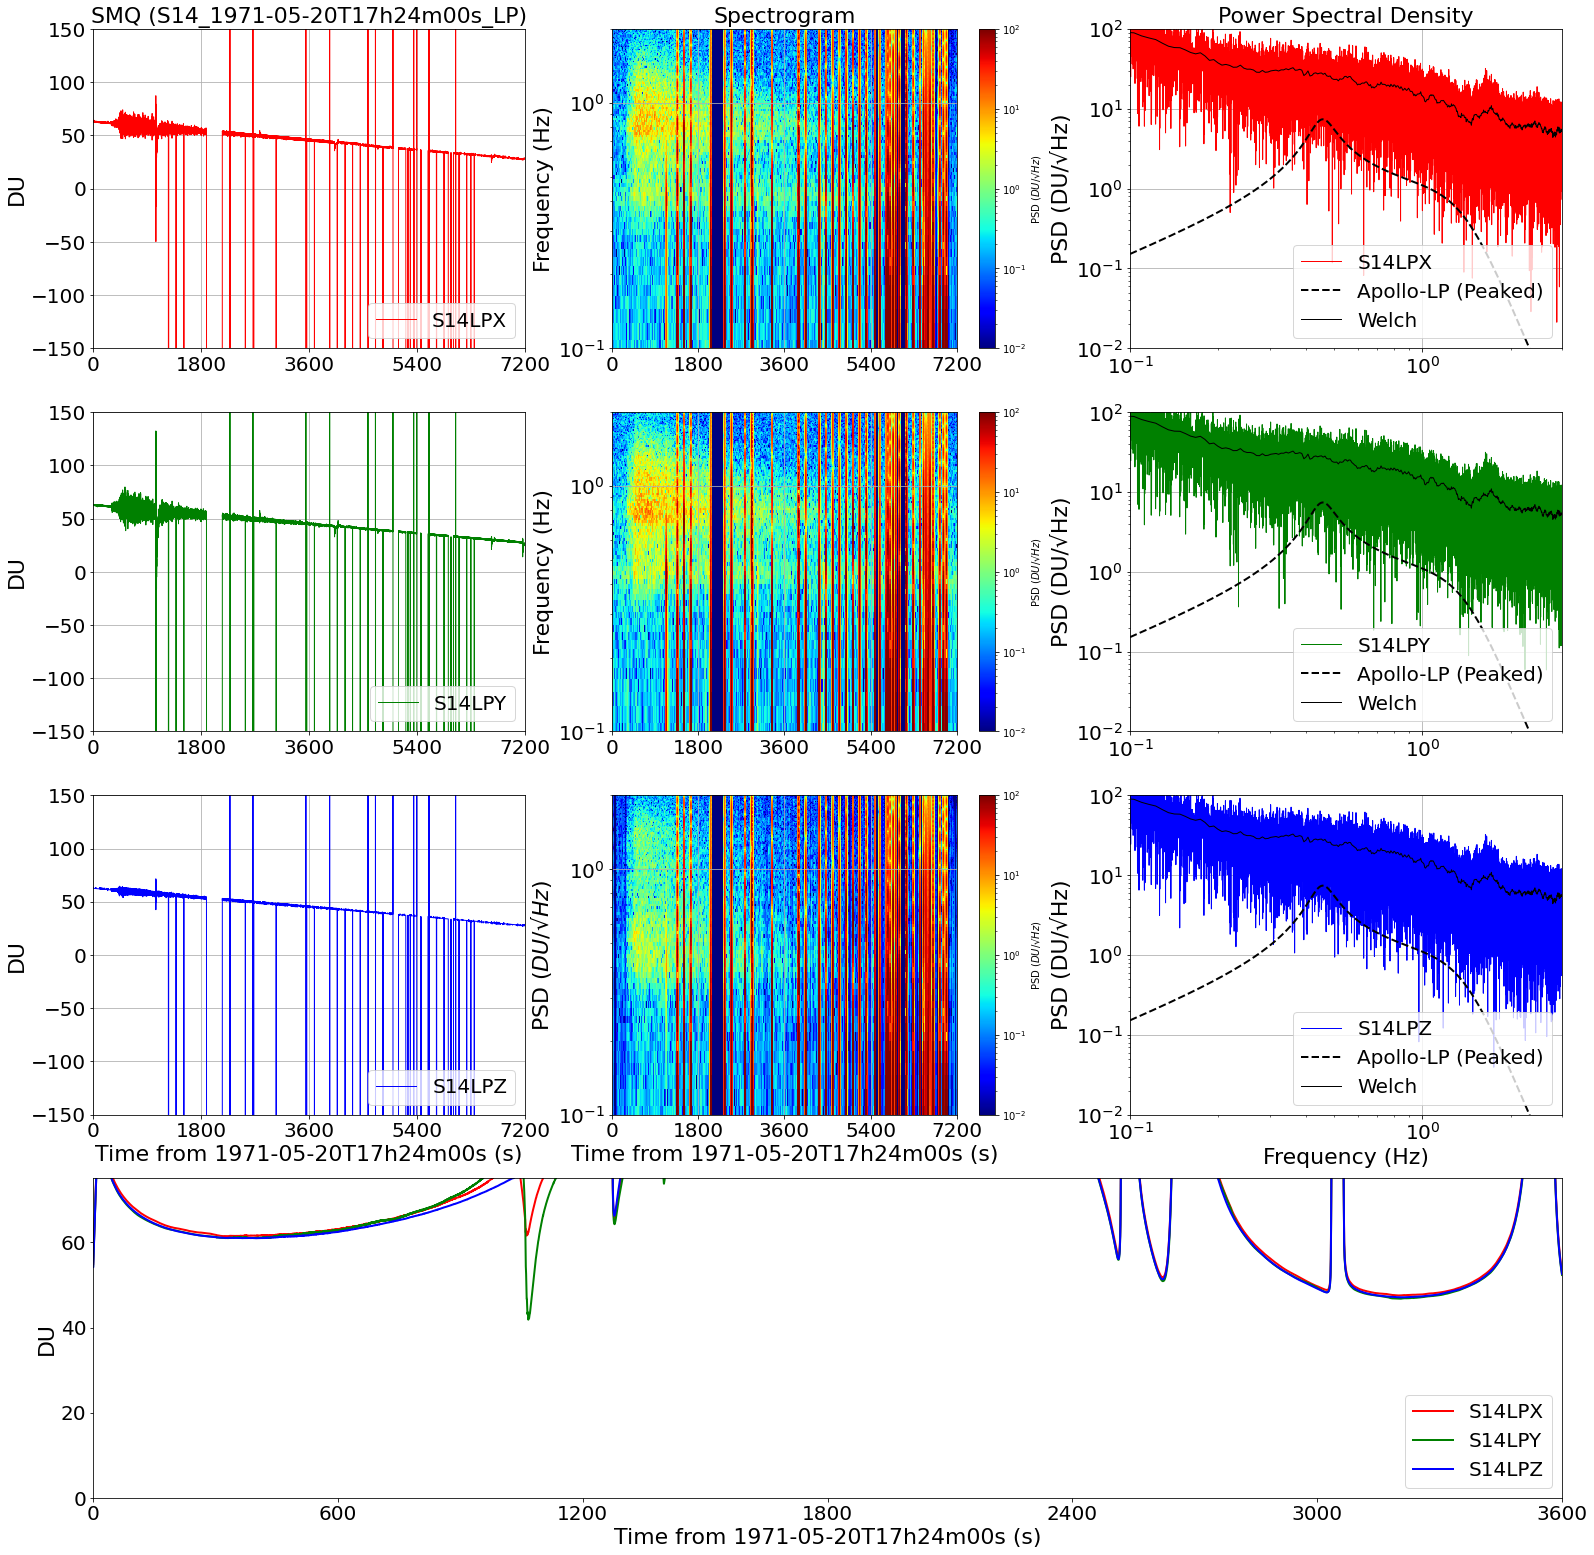

In [14]:
###############################################################
###################      plot 2     ###########################
###############################################################
print("############# Analysis Wave Data #################")
### Convert into Physical Value
print("LPZ (DU)")
DU_lpz.detrend(type='linear') #detrend
DU_lpz.detrend('demean') #rmean
DU_lpz_PSD=DU_lpz[0].data

print("LPX (DU)")
DU_lpx.detrend(type='linear') #detrend
DU_lpx.detrend('demean') #rmean
DU_lpx_PSD=DU_lpx[0].data

print("LPY (DU)")
DU_lpy.detrend(type='linear') #detrend
DU_lpy.detrend('demean') #rmean
DU_lpy_PSD=DU_lpy[0].data

print("SPZ (DU)")
DU_spz.detrend(type='linear') #detrend
DU_spz.detrend('demean') #rmean
DU_spz_PSD=DU_spz[0].data

### Envelope
Env_DU_lpz=obspy.signal.filter.envelope(DU_lpz[0].data)
Env_DU_lpx=obspy.signal.filter.envelope(DU_lpx[0].data)
Env_DU_lpy=obspy.signal.filter.envelope(DU_lpy[0].data)
Env_DU_spz=obspy.signal.filter.envelope(DU_spz[0].data)

### Moving Average
Mv_DU_lpz = np.convolve(Env_DU_lpz, b, mode='same') ## Moving Average (DU)
Mv_DU_lpx = np.convolve(Env_DU_lpx, b, mode='same') ## Moving Average (DU)
Mv_DU_lpy = np.convolve(Env_DU_lpy, b, mode='same') ## Moving Average (DU)
Mv_DU_spz = np.convolve(Env_DU_spz, b, mode='same') ## Moving Average (DU)

print("############# Plot #################")
print("Waveform in DU")
fig = plt.figure(figsize=(24,24))
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)
t_DU_LP = np.linspace(0, DU_lpz[0].data.size*1/f_lp, DU_lpz[0].data.size)
ax = fig.add_subplot(4, 3, 1)
plt.title(title, fontsize=font)
ax.plot(t_DU_LP, DU_lpx[0].data, "r-", label = label_x, linewidth=1.0)
ax.set_ylabel("DU", fontsize=font)
plt.grid()
plt.tick_params(labelsize=font-2)
plt.legend(fontsize=font-2, loc=loc_legend)
ax.set_ylim(-1*DUmax, DUmax)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])
ax = fig.add_subplot(4, 3, 4)
ax.plot(t_DU_LP, DU_lpy[0].data, "g-", label = label_y, linewidth=1.0)
ax.set_ylabel("DU", fontsize=font)
plt.grid()
plt.tick_params(labelsize=font-2)
plt.legend(fontsize=font-2, loc=loc_legend)
ax.set_ylim(-1*DUmax, DUmax)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])
ax = fig.add_subplot(4, 3, 7)
ax.plot(t_DU_LP, DU_lpz[0].data, "b-", label = label_z, linewidth=1.0)
ax.set_ylabel("DU", fontsize=font)
ax.set_xlabel(xlabel, fontsize=font)
plt.grid()
plt.tick_params(labelsize=font-2)
plt.legend(fontsize=font-2, loc=loc_legend)
ax.set_ylim(-1*DUmax, DUmax)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])

print("Envelope")
ax = fig.add_subplot(4, 1, 4)
ax.plot(t_DU_LP, Mv_DU_lpx, "r-", label = label_x, linewidth=2.0)
ax.plot(t_DU_LP, Mv_DU_lpy, "g-", label = label_y, linewidth=2.0)
ax.plot(t_DU_LP, Mv_DU_lpz, "b-", label = label_z, linewidth=2.0)
ax.set_xlim(0, 3600)
ax.set_xticks([0,600,1200,1800, 2400, 3000, 3600])
ax.set_ylim(0, DUmax*0.5)
plt.tick_params(labelsize=font-2)
ax.set_xlabel(xlabel, fontsize=font)
ax.set_ylabel("DU", fontsize=font)
plt.legend(fontsize=font-2, loc=loc_legend)


print("Power Spectral Density in DU/√Hz")
## Normalize
Resp_Peak=abs(AP_h)/np.max(abs(AP_h))
Resp_Flat=abs(AF_h)/np.max(abs(AF_h))
Resp_SP=abs(SP_h)/np.max(abs(SP_h))

ax = fig.add_subplot(4, 3, 3)
plt.title("Power Spectral Density", fontsize=font)
#plt.axvspan(freq_low, freq_high, color='grey', alpha=0.4, lw=0)
fx, Px = signal.periodogram(DU_lpx_PSD, f_lp)
plt.plot(fx, np.sqrt(Px), "r-", linewidth=1.0,label=label_x)
plt.plot(AP_f, (Resp_Peak/np.sqrt(AP_f))*psd_max_DU/20, 'k--', linewidth=2.0,label='Apollo-LP (Peaked)')
fx_wl, Px_wl = signal.welch(DU_lpx_PSD, f_lp , nperseg=1024, noverlap=512, scaling='density', average='mean') 
plt.plot(fx_wl, np.sqrt(Px_wl), "k-", linewidth=1.0,label="Welch")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-1, 3.0)
plt.tick_params(labelsize=font-2)
ax.set_ylim(psd_min_DU, psd_max_DU)
ax.set_ylabel('PSD (DU/√Hz)', fontsize=font)
plt.legend(fontsize=font-2, loc=loc_legend)
plt.grid()
ax = fig.add_subplot(4, 3, 6)
fy, Py = signal.periodogram(DU_lpy_PSD, f_lp)
plt.plot(fy, np.sqrt(Py), "g-", linewidth=1.0,label=label_y)
plt.plot(AP_f, (Resp_Peak/np.sqrt(AP_f))*psd_max_DU/20, 'k--', linewidth=2.0,label='Apollo-LP (Peaked)')
fy_wl, Py_wl = signal.welch(DU_lpy_PSD, f_lp , nperseg=1024, noverlap=512, scaling='density', average='mean') 
plt.plot(fy_wl, np.sqrt(Py_wl), "k-", linewidth=1.0,label="Welch")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-1, 3.0)
plt.tick_params(labelsize=font-2)
ax.set_ylim(psd_min_DU, psd_max_DU)
ax.set_ylabel('PSD (DU/√Hz)', fontsize=font)
plt.legend(fontsize=font-2, loc=loc_legend)
plt.grid()
ax = fig.add_subplot(4, 3, 9)
#plt.axvspan(freq_low, freq_high, color='grey', alpha=0.4, lw=0)
fz, Pz = signal.periodogram(DU_lpz_PSD, f_lp)
plt.plot(fz, np.sqrt(Pz), "b-", linewidth=1.0,label=label_z)
plt.plot(AP_f, (Resp_Peak/np.sqrt(AP_f))*psd_max_DU/20, 'k--', linewidth=2.0,label='Apollo-LP (Peaked)')
fz_wl, Pz_wl = signal.welch(DU_lpz_PSD, f_lp , nperseg=1024, noverlap=512, scaling='density', average='mean') 
plt.plot(fz_wl, np.sqrt(Pz_wl), "k-", linewidth=1.0,label="Welch")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-1, 3.0)
plt.tick_params(labelsize=font-2)
ax.set_ylim(psd_min_DU, psd_max_DU)
ax.set_xlabel('Frequency (Hz)', fontsize=font)
ax.set_ylabel('PSD (DU/√Hz)', fontsize=font)
plt.legend(fontsize=font-2, loc=loc_legend)
plt.grid()
print("Spectrogram")
ax = fig.add_subplot(4, 3, 2)
plt.title("Spectrogram", fontsize=font)
fx,tx,Sx = signal.spectrogram(DU_lpx[0].data, nfft=int(f_lp*time), nperseg=int(f_lp*time), fs=int(f_lp), noverlap=int(f_lp*time-1), scaling='density',mode='psd', window=('hamming'))
#plt.pcolormesh(tx,fx,np.sqrt(Sx), cmap=cmap, norm=colors.LogNorm())
plt.pcolormesh(tx,fx,np.sqrt(Sx), cmap=cmap, norm=colors.LogNorm(vmin=psd_min_DU, vmax=psd_max_DU))
ax.set_ylabel("Frequency (Hz)", fontsize=font)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])
ax.set_ylim(0.1, 2.0)
plt.tick_params(labelsize=font-2)
ax.set_yscale("log")
plt.colorbar(orientation ='vertical', label='PSD ($DU/√Hz$)')
plt.grid(which='major')
ax = fig.add_subplot(4, 3, 5)
fy,ty,Sy = signal.spectrogram(DU_lpy[0].data, nfft=int(f_lp*time), nperseg=int(f_lp*time), fs=int(f_lp), noverlap=int(f_lp*time-1), scaling='density',mode='psd', window=('hamming'))
#plt.pcolormesh(ty,fy,np.sqrt(Sy), cmap=cmap, norm=colors.LogNorm())
plt.pcolormesh(ty,fy,np.sqrt(Sy), cmap=cmap, norm=colors.LogNorm(vmin=psd_min_DU, vmax=psd_max_DU))
ax.set_ylabel("Frequency (Hz)", fontsize=font)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])
ax.set_ylim(0.1, 2.0)
plt.tick_params(labelsize=font-2)
ax.set_yscale("log")
plt.colorbar(orientation ='vertical', label='PSD ($DU/√Hz$)')
plt.grid(which='major')
ax = fig.add_subplot(4, 3, 8)
fz,tz,Sz = signal.spectrogram(DU_lpz[0].data, nfft=int(f_lp*time), nperseg=int(f_lp*time), fs=int(f_lp), noverlap=int(f_lp*time-1), scaling='density',mode='psd', window=('hamming'))
#plt.pcolormesh(tz,fz,np.sqrt(Sz), cmap=cmap, norm=colors.LogNorm())
plt.pcolormesh(tz,fz,np.sqrt(Sz), cmap=cmap, norm=colors.LogNorm(vmin=psd_min_DU, vmax=psd_max_DU))
ax.set_ylabel("Frequency (Hz)", fontsize=font)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])
ax.set_ylim(0.1, 2.0)
plt.tick_params(labelsize=font-2)
ax.set_yscale("log")
plt.colorbar(orientation ='vertical', label='PSD ($DU/√Hz$)')
plt.grid(which='major')
ax.set_ylabel('PSD ($DU/√Hz$)')
ax.set_xlabel(xlabel, fontsize=font)
plt.show()

############# Plot (SP) #################
Waveform in nm/s
Spectrogram
Power Spectral Density in nm/s/√Hz


<ipython-input-15-03fe2cfd3aba>:33: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(tx,fx,np.sqrt(Sx), cmap=cmap, norm=colors.LogNorm(vmin=psd_min, vmax=psd_max/2))
<ipython-input-15-03fe2cfd3aba>:47: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(tx,fx,np.sqrt(Sx), cmap=cmap, norm=colors.LogNorm(vmin=psd_min, vmax=psd_max/2))


Envelope


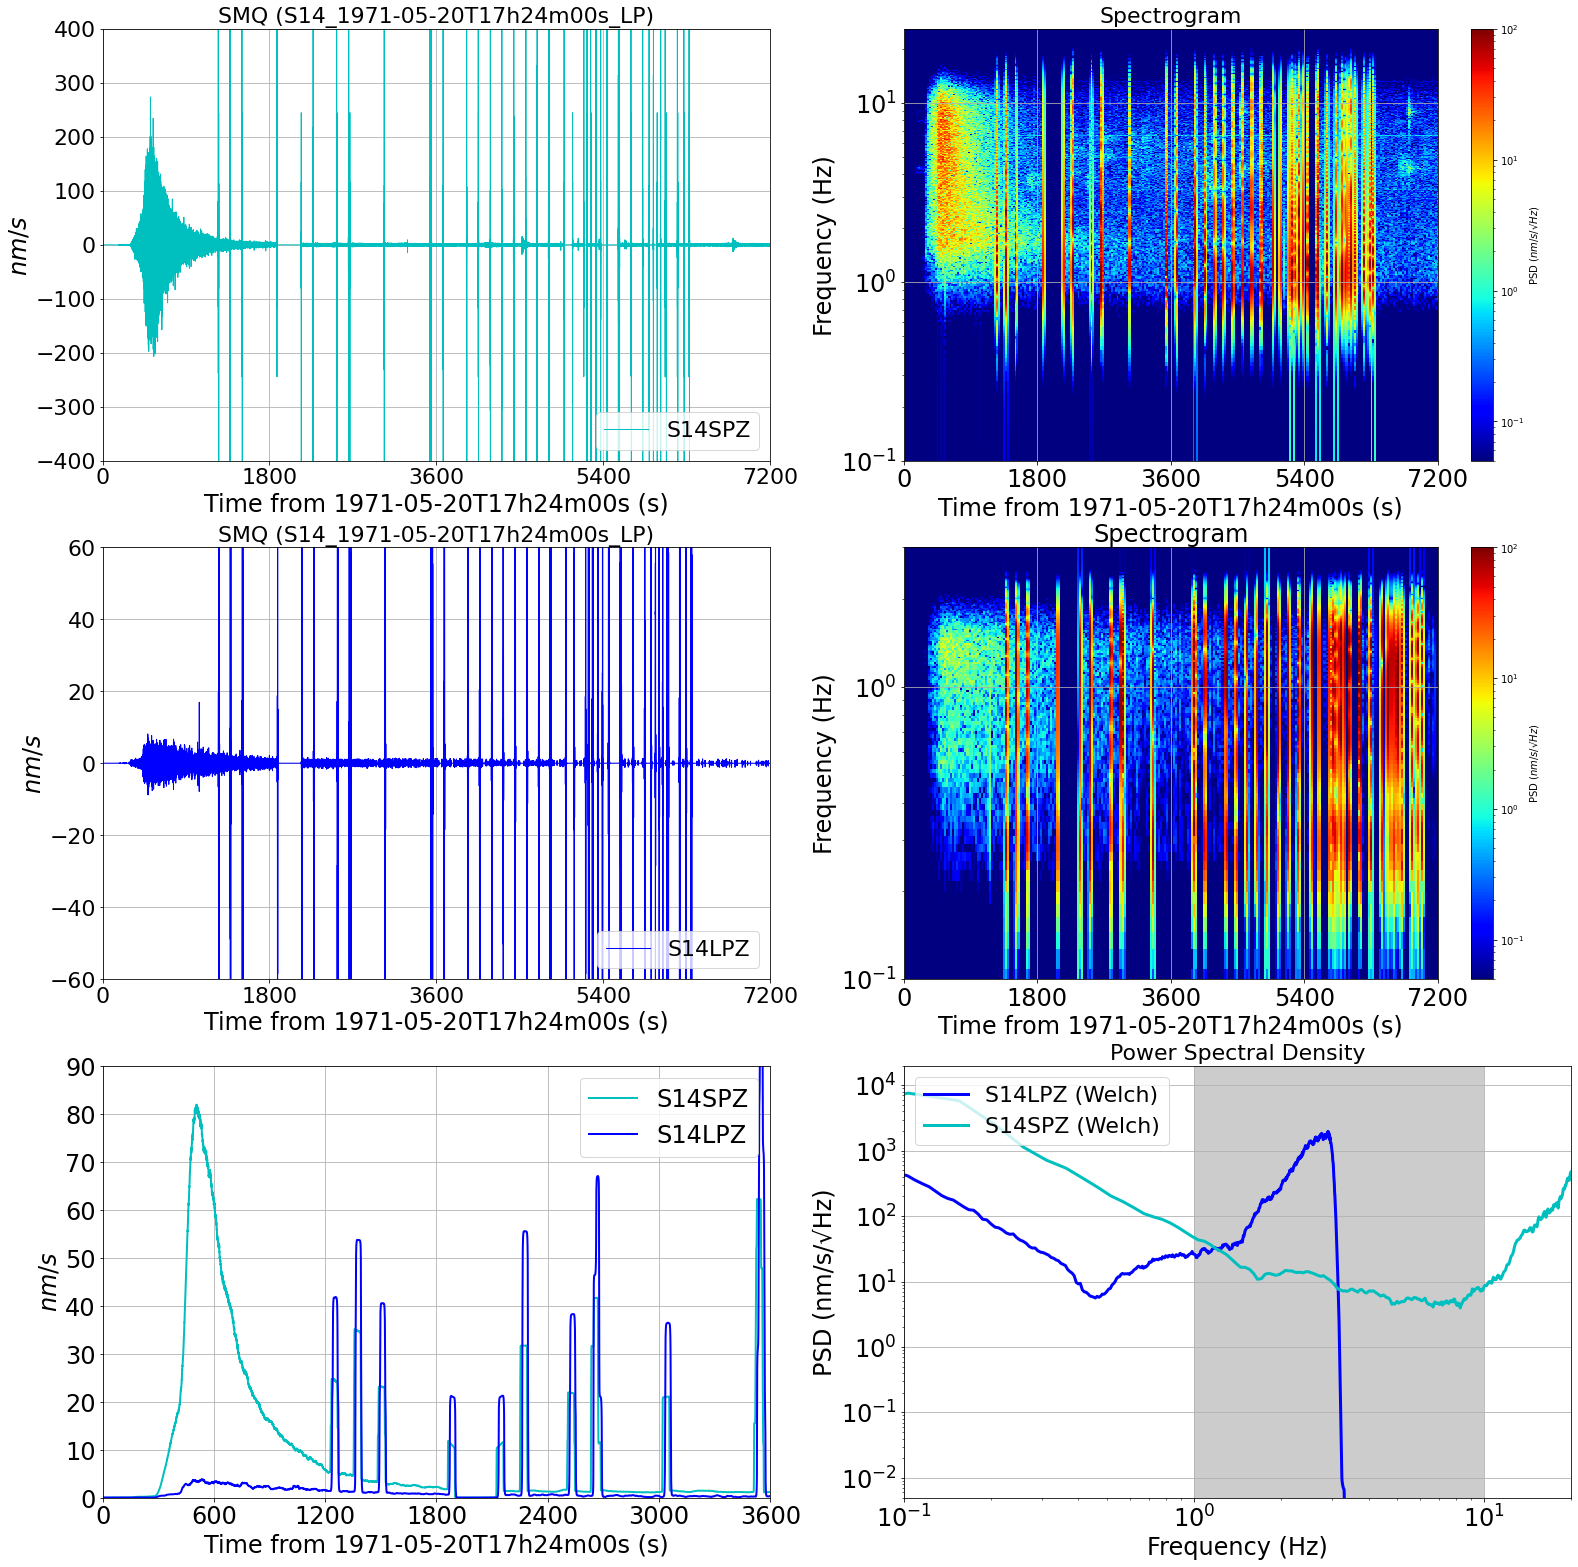

In [15]:
print("############# Plot (SP) #################")
print("Waveform in nm/s")
fig = plt.figure(figsize=(24,24))
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)
t_NI_SP = np.linspace(0, st_NI1_spz[0].data.size*1/f_sp, st_NI1_spz[0].data.size)
ax = fig.add_subplot(3, 2, 1)
plt.title(title, fontsize=font)
ax.plot(t_NI_SP, st_NI1_spz[0].data*1e9, "c-", label = label_sp, linewidth=1.0)
ax.set_ylabel(ylabel, fontsize=font+2)
ax.set_xlabel(xlabel, fontsize=font+2)
plt.grid()
plt.tick_params(labelsize=font)
plt.legend(fontsize=font, loc=loc_legend)
ax.set_ylim(-10*ymax, 10*ymax)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])
ax = fig.add_subplot(3, 2, 3)
plt.title(title, fontsize=font)
ax.plot(t_NI_LP, st_NI1_lpz[0].data*1e9, "b-", label = label_z, linewidth=1.0)
ax.set_ylabel(ylabel, fontsize=font+2)
ax.set_xlabel(xlabel, fontsize=font+2)
plt.grid()
plt.tick_params(labelsize=font)
plt.legend(fontsize=font, loc=loc_legend)
ax.set_ylim(-1.5*ymax, 1.5*ymax)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])

print("Spectrogram")
ax = fig.add_subplot(3, 2, 2)
plt.title("Spectrogram", fontsize=font)
fx,tx,Sx = signal.spectrogram(st_NI1_spz[0].data*1e9, nfft=int(f_sp*time), nperseg=int(f_sp*time), fs=int(f_sp), noverlap=int(f_sp*time/2), scaling='density',mode='psd', window=('hamming'))
plt.pcolormesh(tx,fx,np.sqrt(Sx), cmap=cmap, norm=colors.LogNorm(vmin=psd_min, vmax=psd_max/2))
ax.set_ylabel("Frequency (Hz)", fontsize=font+2)
ax.set_xlabel(xlabel, fontsize=font+2)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])
ax.set_ylim(0.1, 26)
ax.set_yticks([0.1,0.5, 1.0, 5.0, 10, 20])
plt.tick_params(labelsize=font+2)
ax.set_yscale("log")
plt.colorbar(orientation ='vertical', label='PSD ($nm/s/√Hz$)')
plt.grid(which='major')
ax = fig.add_subplot(3, 2, 4)
plt.title("Spectrogram", fontsize=font+2)
fx,tx,Sx = signal.spectrogram(st_NI1_lpz[0].data*1e9, nfft=int(f_lp*time), nperseg=int(f_lp*time), fs=int(f_lp), noverlap=int(f_lp*time/2), scaling='density',mode='psd', window=('hamming'))
plt.pcolormesh(tx,fx,np.sqrt(Sx), cmap=cmap, norm=colors.LogNorm(vmin=psd_min, vmax=psd_max/2))
ax.set_ylabel("Frequency (Hz)", fontsize=font+2)
ax.set_xlabel(xlabel, fontsize=font+2)
ax.set_xlim(0, 7200)
ax.set_xticks([0,1800, 3600, 5400, 7200])
ax.set_ylim(0.1, 3)
ax.set_yticks([0.1,0.5, 1.0, 2.0])
plt.tick_params(labelsize=font+2)
ax.set_yscale("log")
plt.colorbar(orientation ='vertical', label='PSD ($nm/s/√Hz$)')
plt.grid(which='major')


print("Power Spectral Density in nm/s/√Hz")
ax = fig.add_subplot(3, 2, 6)
plt.title("Power Spectral Density", fontsize=font)
plt.axvspan(freq_low_sp, freq_high_sp, color='grey', alpha=0.4, lw=0)
#fz, Pz = signal.periodogram(st_NI1_lpz_PSD*1e9, f_lp)
#plt.plot(fz, np.sqrt(Pz), "b-", linewidth=1.0,label=label_z) 
#fsp, Psp = signal.periodogram(st_NI1_spz_PSD*1e9, f_sp)
#plt.plot(fsp, np.abs(Psp), "c-", linewidth=1.0,label=label_sp)
fz_wl, Pz_wl = signal.welch(st_NI1_lpz_PSD*1e9, f_lp , nperseg=1024, noverlap=512, scaling='density', average='mean')
plt.plot(fz_wl, np.sqrt(Pz_wl), "b-", linewidth=3.0,label="S14LPZ (Welch)")
fx_wl, Px_wl = signal.welch(st_NI1_spz_PSD*1e9, f_sp, nperseg=1024, noverlap=512, scaling='density', average='mean') 
plt.plot(fx_wl, np.sqrt(Px_wl), "c-", linewidth=3.0,label="S14SPZ (Welch)")
ax.set_xlim(1e-1, 20)
ax.set_xscale("log")
ax.set_yscale("log")
plt.tick_params(labelsize=font+2)
ax.set_ylim(psd_min*1e-1, psd_max*1e2)
ax.set_xlabel('Frequency (Hz)', fontsize=font+2)
ax.set_ylabel('PSD (nm/s/√Hz)', fontsize=font+2)
plt.legend(fontsize=font, loc='upper left')
plt.grid()

print("Envelope")
ax = fig.add_subplot(3, 2, 5)
#plt.plot(t_NI_SP, np.abs(st_NI1_spz[0].data*1e9), "c-", label = label_sp, linewidth=2.0)
plt.plot(t_NI_SP, Mv_NI1_spz, "c-", label = label_sp, linewidth=2.0)
plt.plot(t_NI_LP, Mv_NI1_lpz, "b-", label = label_z, linewidth=2.0)
ax.set_xlim(0, 3600)
ax.set_ylim(0, DUmax*0.6)
plt.tick_params(labelsize=font+2)
ax.set_xticks([0,600,1200,1800, 2400, 3000, 3600])
ax.set_xlabel(xlabel, fontsize=font+2)
ax.set_ylabel("$nm/s$", fontsize=font+2)
plt.legend(fontsize=font+2, loc='upper right')
plt.grid()
plt.show()

############# Plot (SP: DU) #################
Envelope


<ipython-input-16-5fdf79ca5c67>:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(tz,fz,np.sqrt(Sz), cmap=cmap, norm=colors.LogNorm(vmin=psd_min_DU, vmax=psd_max_DU))
<ipython-input-16-5fdf79ca5c67>:33: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(SP_f, (Resp_SP/np.sqrt(SP_f))*psd_max_DU/2, 'k--', linewidth=2.0,label='Apollo-SP')
<ipython-input-16-5fdf79ca5c67>:34: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(AP_f, (Resp_Peak/np.sqrt(AP_f))*psd_max_DU/2, 'c--', linewidth=2.0,label='Apollo-LP')


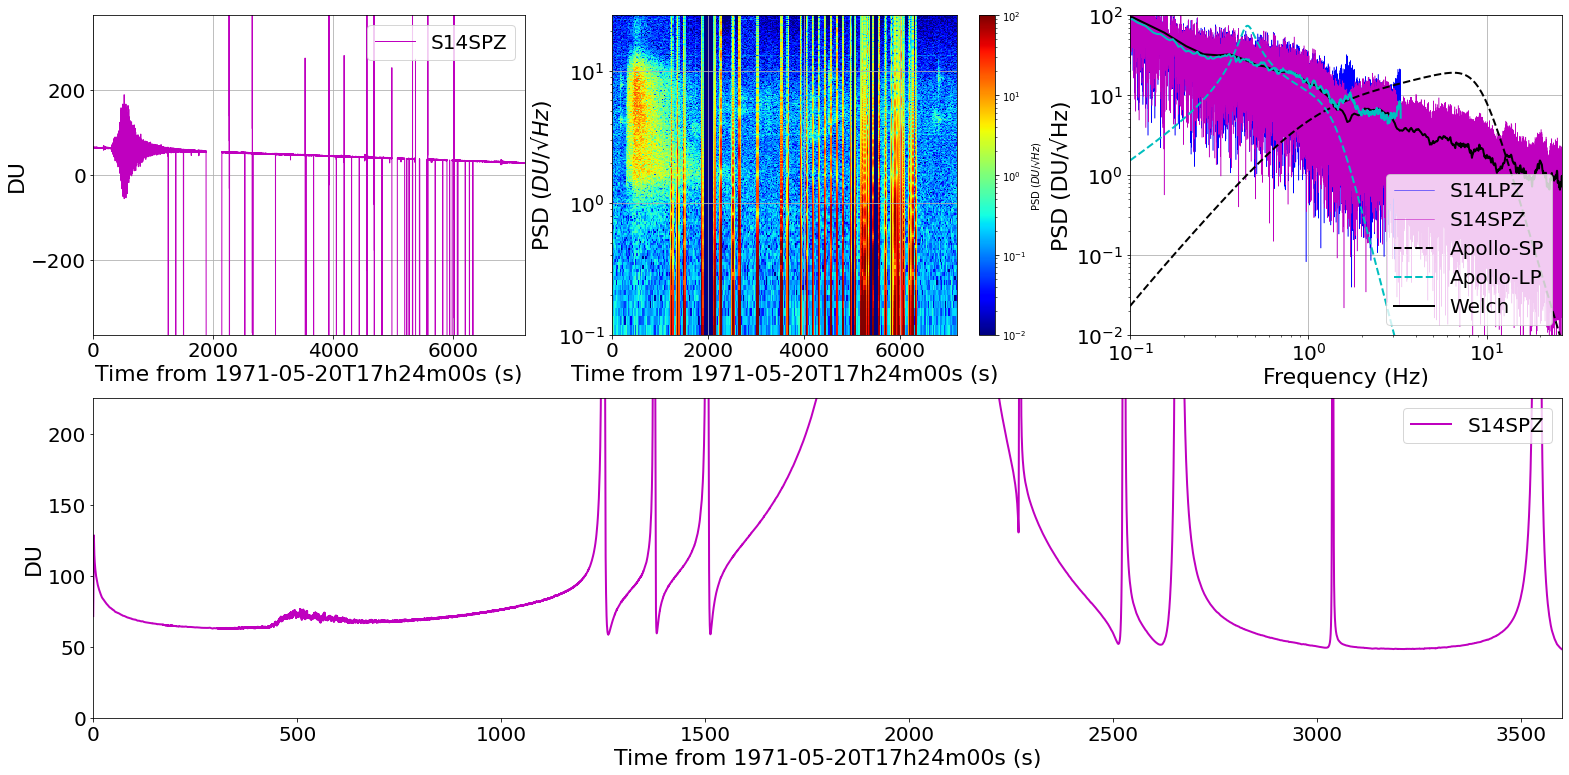

In [16]:
print("############# Plot (SP: DU) #################")
fig = plt.figure(figsize=(24,24))
plt.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95)
ax = fig.add_subplot(4, 3, 7)
ax.plot(t_NI_SP, DU_spz[0].data, "m-", label = label_sp, linewidth=1.0)
ax.set_ylabel("DU", fontsize=font)
ax.set_xlabel(xlabel, fontsize=font)
plt.grid()
plt.tick_params(labelsize=font-2)
plt.legend(fontsize=font-2, loc='upper right')
ax.set_ylim(-2.5*DUmax, 2.5*DUmax)
ax.set_xlim(0, 7200)

ax = fig.add_subplot(4, 3, 8)
fz,tz,Sz = signal.spectrogram(DU_spz[0].data, nfft=int(f_sp*time), nperseg=int(f_sp*time), fs=int(f_sp), noverlap=int(f_sp*time/2), scaling='density',mode='psd', window=('hamming'))
plt.pcolormesh(tz,fz,np.sqrt(Sz), cmap=cmap, norm=colors.LogNorm(vmin=psd_min_DU, vmax=psd_max_DU))
ax.set_ylabel("Frequency (Hz)", fontsize=font)
ax.set_xlim(0, 7200)
ax.set_ylim(0.1, f_sp/2)
plt.tick_params(labelsize=font-2)
ax.set_yscale("log")
plt.colorbar(orientation ='vertical', label='PSD ($DU/√Hz$)')
plt.grid(which='major')
ax.set_ylabel('PSD ($DU/√Hz$)')
ax.set_xlabel(xlabel, fontsize=font)

ax = fig.add_subplot(4, 3, 9)
#plt.axvspan(freq_low, freq_high, color='grey', alpha=0.4, lw=0)
fz, Pz = signal.periodogram(DU_lpz_PSD, f_lp)
plt.plot(fz, np.sqrt(Pz), "b-", linewidth=0.5,label=label_z)
fz, Pz = signal.periodogram(DU_spz_PSD, f_sp)
plt.plot(fz, np.sqrt(Pz), "m-", linewidth=0.5,label=label_sp)
plt.plot(SP_f, (Resp_SP/np.sqrt(SP_f))*psd_max_DU/2, 'k--', linewidth=2.0,label='Apollo-SP')
plt.plot(AP_f, (Resp_Peak/np.sqrt(AP_f))*psd_max_DU/2, 'c--', linewidth=2.0,label='Apollo-LP')
fz_wl, Pz_wl = signal.welch(DU_spz_PSD, f_sp , nperseg=1024, noverlap=512, scaling='density', average='mean') 
plt.plot(fz_wl, np.sqrt(Pz_wl), "k-", linewidth=2.0,label="Welch")
fz_wl, Pz_wl = signal.welch(DU_lpz_PSD, f_lp , nperseg=1024, noverlap=512, scaling='density', average='mean') 
plt.plot(fz_wl, np.sqrt(Pz_wl), "c-", linewidth=2.0)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1e-1, f_sp/2)
plt.tick_params(labelsize=font-2)
ax.set_ylim(psd_min_DU, psd_max_DU)
ax.set_xlabel('Frequency (Hz)', fontsize=font)
ax.set_ylabel('PSD (DU/√Hz)', fontsize=font)
plt.legend(fontsize=font-2, loc=loc_legend)
plt.grid()

print("Envelope")
ax = fig.add_subplot(4, 1, 4)
ax.plot(t_NI_SP, Mv_DU_spz, "m-", label = label_sp, linewidth=2.0)
ax.set_xlim(0, 3600)
ax.set_ylim(0, DUmax*1.5)
plt.tick_params(labelsize=font-2)
ax.set_xlabel(xlabel, fontsize=font)
ax.set_ylabel("DU", fontsize=font)
plt.legend(fontsize=font-2, loc="upper right")

plt.show()